Importamos las librerías que vamos a usar

In [2]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings

Para manipular el archivo Excel usando Python instalamos la dependencia e importamos la biblioteca arriba

In [3]:
pip install openpyxl 

Note: you may need to restart the kernel to use updated packages.


#### Importamos el Dataset de Internet

In [4]:
# Leer todas las hojas del archivo Excel
internet_dataset = "Datasets\Internet.xlsx"
internet_file = pd.ExcelFile(internet_dataset)

<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\2447630919.py:2: SyntaxWarning: invalid escape sequence '\I'
  internet_dataset = "Datasets\Internet.xlsx"


#### Importamos las hojas que vamos a usar

In [5]:
accesos_por_tecnologia = pd.read_excel(internet_file, sheet_name='Accesos Por Tecnología') # Accesos por Tecnología
Totales_acc_tecno = pd.read_excel(internet_file, sheet_name='Totales Accesos Por Tecnología')

penetracion_hogares = pd.read_excel(internet_file, sheet_name='Penetracion-hogares') # penetración por hogar
penetracion_poblacion = pd.read_excel(internet_file, sheet_name='Penetración-poblacion')

acc_por_velocidad = pd.read_excel(internet_file, sheet_name='Accesos por velocidad')

Dial_BAf = pd.read_excel(internet_file, sheet_name='Dial-BAf')
ingresos = pd.read_excel(internet_file, sheet_name='Ingresos ')

Utilizaremos las hojas que se consideraron relevantes_
- Accesos por Tecnología / Totales Accesos por Tecnología:
son fundamentales para analizar la distribución y evolución del acceso a internet por tipo de tecnología (ADSL, fibra óptica, etc.). Es clave para entender qué tecnologías están siendo preferidas en diferentes regiones y permite identificar áreas donde sería necesario mejorar la infraestructura o expandir nuevas tecnologías, como la fibra óptica, para mejorar la calidad del servicio y aumentar la penetración.

- Penetración por Hogar:
Ofrecen una visión de la penetración del servicio de internet en los hogares, lo que es crítico para evaluar el alcance del servicio en relación a la población y los hogares de cada provincia. Con esta información, la empresa puede determinar en qué áreas está más presente y dónde tiene oportunidades de crecimiento. También permite identificar brechas entre la penetración de internet y la demanda potencial de acceso, lo que puede informar decisiones estratégicas.

- Accesos por Velocidad:
Para entender las demandas de ancho de banda de los usuarios. Esto ayuda a la empresa a identificar si la infraestructura existente satisface las necesidades actuales de velocidad de conexión o si hay regiones donde los usuarios están limitados a velocidades bajas. Esta información es vital para mejorar el servicio, optimizar la oferta y prever futuras demandas tecnológicas.

- Dial-BAf:
Proporciona una perspectiva histórica sobre el uso de tecnologías más antiguas como el dial-up y su transición hacia conexiones de banda ancha. Analizar estas tendencias ayuda a la empresa a monitorear el declive de las tecnologías obsoletas y planificar la reasignación de recursos hacia tecnologías más modernas.

- Ingresos:
Para analizar el rendimiento financiero de la empresa en diferentes periodos. Permite a la empresa evaluar la rentabilidad de sus servicios por región y tecnología, y ajustar su estrategia comercial. Comparar los ingresos con los accesos puede ayudar a identificar mercados más rentables o detectar áreas con potencial para aumentar la monetización de sus servicios.

- penetracion_poblacion: para complementar el panorama general y pensando en los kPIS

Se usa el metodo head() de pandas para poder visualizar las columnas, con el fin de tener una noción a nivel general sobre su composición y estadísticas.

In [6]:
'''
# Recorrer todas las hojas para obtener un resumen descriptivo
for hoja in internet_file.sheet_names:
    print(f"\n--- Resumen de la hoja: {hoja} ---")
    df = pd.read_excel(internet_file, sheet_name=hoja)
    
    # Información general
    print("Información del DataFrame:")
    print(df.info())
    
    # Resumen estadístico
    print("\nResumen estadístico:")
    print(df.describe(include='all'))

    # Revisar valores nulos
    print("\nValores nulos por columna:")
    print(df.isnull().sum())
    
    # Revisar los primeros 5 datos para tener una idea de la estructura
    print("\nPrimeras 5 filas:")
    print(df.head())'''

'\n# Recorrer todas las hojas para obtener un resumen descriptivo\nfor hoja in internet_file.sheet_names:\n    print(f"\n--- Resumen de la hoja: {hoja} ---")\n    df = pd.read_excel(internet_file, sheet_name=hoja)\n    \n    # Información general\n    print("Información del DataFrame:")\n    print(df.info())\n    \n    # Resumen estadístico\n    print("\nResumen estadístico:")\n    print(df.describe(include=\'all\'))\n\n    # Revisar valores nulos\n    print("\nValores nulos por columna:")\n    print(df.isnull().sum())\n    \n    # Revisar los primeros 5 datos para tener una idea de la estructura\n    print("\nPrimeras 5 filas:")\n    print(df.head())'

Análisis de las hojas que se consideran relevantes para el trabajo:
- Accesos por Velocidad:
Hay valores nulos en la columna OTROS. Las demás columnas están completas.

- Totales Accesos por Tecnología:
No presenta valores nulos. El estado de los datos es sólido.

- Accesos por Tecnología: 
__Año, Trimestre: Formato object en lugar de int64, debería corregirse.__

- Penetracion-hogares:
No hay valores nulos, lo cual sugiere que esta hoja está bien estructurada y completa.

- Dial-BAf:
Existen algunos valores nulos en la columna Dial up, pero las demás columnas están completas.

- Ingresos:
Los datos en la hoja están completos y en el formato correcto, con los tipos de datos adecuados para cada columna.

#### Analizamos un poco el contenido de las hojas para ver qué podemos elaborar sobre ellas, empezando con accesos por tecnología

In [7]:
accesos_por_tecnologia.head(5)

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2024,1,Buenos Aires,203297.0,2790663.0,1799013.0,150290.0,101294.0,5044557.0
1,2024,1,Capital Federal,70108.0,1177475.0,203756.0,4493.0,48879.0,1504711.0
2,2024,1,Catamarca,5901.0,11025.0,56542.0,1384.0,81.0,74933.0
3,2024,1,Chaco,11343.0,58929.0,64463.0,8404.0,12404.0,155543.0
4,2024,1,Chubut,26306.0,77217.0,26356.0,30867.0,9930.0,170676.0


Vemos que año y trimestre están en formato object. Indica que deben ser cambiados a int

In [8]:
accesos_por_tecnologia.dtypes

Año              object
Trimestre        object
Provincia        object
ADSL            float64
Cablemodem      float64
Fibra óptica    float64
Wireless        float64
Otros           float64
Total           float64
dtype: object

Al querer cambiar a entero nos percatamos de que en las celdas del año 2019 y algunos trimestres, los valores al final tenían un asterísco, los cuales a posterior serían un problema y tampoco se nos permitiría cambiarlos a enteros si tienen estos valores.

In [9]:
# Filtrar las filas donde la columna 'Año' o 'Trimestre' contenga un asterisco
filas_con_asterisco = accesos_por_tecnologia[(accesos_por_tecnologia['Año'].astype(str).str.contains(r'\*')) | 
                                             (accesos_por_tecnologia['Trimestre'].astype(str).str.contains(r'\*'))]

# Mostrar las filas que contienen asteriscos
filas_con_asterisco.head(5)

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
432,2019 *,3 *,Buenos Aires,1277249.0,2144956.0,425386.0,85572.0,27070.0,3960233.0
433,2019 *,3 *,Capital Federal,300288.0,1080973.0,24900.0,3895.0,31155.0,1441211.0
434,2019 *,3 *,Catamarca,24349.0,5543.0,13.0,244.0,2251.0,32400.0
435,2019 *,3 *,Chaco,50416.0,49156.0,8063.0,5224.0,1592.0,114451.0
436,2019 *,3 *,Chubut,37298.0,27090.0,1917.0,15149.0,7551.0,89005.0


Vamos a corregirlo con el método replace(). Para buscar el asterisco con \*. Esto lo elimina en las columnas 'Año' y 'Trimestre'. Luego lo convertimos a numérico ya que al tener asterisco era considerado como string. El argumento errors='coerce', convierte cualquier valor no convertible a NaN, lo que ayuda a manejar datos sucios de manera eficiente

In [10]:
# Reemplazar el asterisco en las columnas 'Año' y 'Trimestre'
accesos_por_tecnologia['Año'] = accesos_por_tecnologia['Año'].replace(r'\*', '', regex=True)
accesos_por_tecnologia['Trimestre'] = accesos_por_tecnologia['Trimestre'].replace(r'\*', '', regex=True)

# Convertir a tipo numérico después de eliminar los asteriscos
accesos_por_tecnologia['Año'] = pd.to_numeric(accesos_por_tecnologia['Año'], errors='coerce')
accesos_por_tecnologia['Trimestre'] = pd.to_numeric(accesos_por_tecnologia['Trimestre'], errors='coerce')

# Mostrar el DataFrame para verificar los cambios
accesos_por_tecnologia.head(5)

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2024.0,1.0,Buenos Aires,203297.0,2790663.0,1799013.0,150290.0,101294.0,5044557.0
1,2024.0,1.0,Capital Federal,70108.0,1177475.0,203756.0,4493.0,48879.0,1504711.0
2,2024.0,1.0,Catamarca,5901.0,11025.0,56542.0,1384.0,81.0,74933.0
3,2024.0,1.0,Chaco,11343.0,58929.0,64463.0,8404.0,12404.0,155543.0
4,2024.0,1.0,Chubut,26306.0,77217.0,26356.0,30867.0,9930.0,170676.0


Además, antes de pasarlos a enteros debemos resolver los nulos, sino no podemos. Así que procedemos a eliminarlos ya que no son muchos y no afectarían de gran manera al análisis.

In [11]:
accesos_por_tecnologia.isnull().sum()

Año             2
Trimestre       2
Provincia       2
ADSL            2
Cablemodem      2
Fibra óptica    2
Wireless        2
Otros           2
Total           2
dtype: int64

In [12]:
# Eliminar las filas con valores nulos en cualquier columna
accesos_por_tecnologia.dropna(inplace=True) 
print(accesos_por_tecnologia.isnull().sum())

Año             0
Trimestre       0
Provincia       0
ADSL            0
Cablemodem      0
Fibra óptica    0
Wireless        0
Otros           0
Total           0
dtype: int64


Finalmente convertimos a enteros.

In [13]:
# Convertir Año y Trimestre a formato numérico
accesos_por_tecnologia['Año'] = accesos_por_tecnologia['Año'].astype(int)
accesos_por_tecnologia['Trimestre'] = accesos_por_tecnologia['Trimestre'].astype(int)

# Verificar los tipos de datos nuevamente
print(accesos_por_tecnologia.dtypes)

Año               int32
Trimestre         int32
Provincia        object
ADSL            float64
Cablemodem      float64
Fibra óptica    float64
Wireless        float64
Otros           float64
Total           float64
dtype: object


#### Analizamos que hay en penetración de hogares antes de empezar a analizar en conjunto

In [14]:
penetracion_hogares.head()

,Año,Trimestre,Provincia,Accesos por cada 100 hogares
0,2024,1,Buenos Aires,81.10
1,2024,1,Capital Federal,119.53
2,2024,1,Catamarca,68.82
3,2024,1,Chaco,46.70
4,2024,1,Chubut,84.89


Para calcular el promedio (mean()), es necesario asegurarse de que solo las columnas numéricas se utilicen para realizar estos cálculos estadísticos como mean. Por ello primero seleccionamos las columnas numéricas antes de agrupar por provincia, para evitar problemas al calcular los promedios. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\502148078.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accesos_tecnologia_por_provincia, x='Provincia', y='Total', palette='viridis')


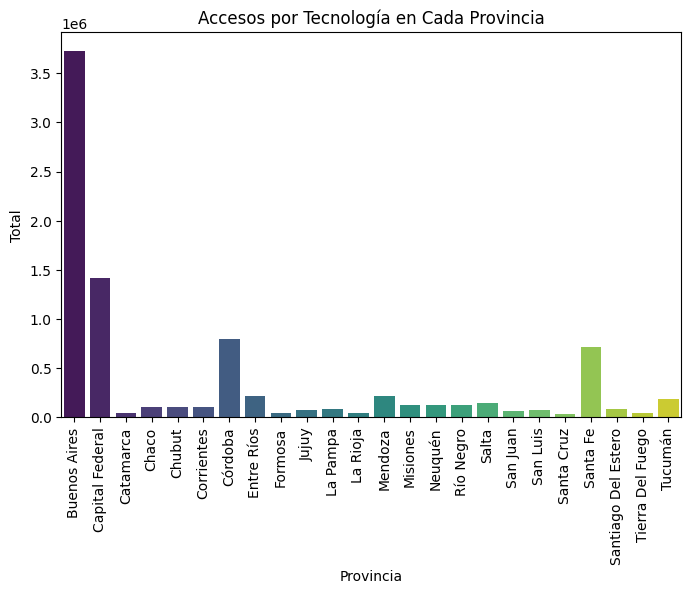

In [15]:
# Seleccionar solo las columnas numéricas antes de agrupar
accesos_tecnologia_numericas = accesos_por_tecnologia.select_dtypes(include='number')
penetracion_hogares_numericas = penetracion_hogares.select_dtypes(include='number')

# Asegurarse de que 'Provincia' siga siendo parte del DataFrame
accesos_tecnologia_numericas['Provincia'] = accesos_por_tecnologia['Provincia']
penetracion_hogares_numericas['Provincia'] = penetracion_hogares['Provincia']

# Agrupamos los datos por provincia y calculamos el promedio de los accesos por tecnología y penetración por hogares
accesos_tecnologia_por_provincia = accesos_tecnologia_numericas.groupby('Provincia').mean().reset_index()
penetracion_por_hogares = penetracion_hogares_numericas.groupby('Provincia').mean().reset_index()

# Crear gráfico de barras para los accesos por tecnología
plt.figure(figsize=(8, 5))
sns.barplot(data=accesos_tecnologia_por_provincia, x='Provincia', y='Total', palette='viridis')
plt.xticks(rotation=90)
plt.title('Accesos por Tecnología en Cada Provincia')
plt.show()

- Dominio de Buenos Aires y Capital Federal: Claramente, Buenos Aires y Capital Federal tienen el mayor número de accesos totales a internet, lo que sugiere una alta concentración de usuarios en estas áreas. Esto podría indicar una mayor demanda y penetración del servicio en las zonas más urbanizadas y desarrolladas.

- Bajo Nivel de Accesos en Provincias Menores: Provincias como Catamarca, La Rioja, Formosa y San Luis muestran un nivel considerablemente más bajo de accesos, lo que podría señalar una oportunidad de expansión de infraestructura y servicios de internet en estas regiones.

- Desigualdad en el Acceso: Existe una disparidad significativa en la cantidad de accesos entre las provincias, lo que sugiere que las inversiones en infraestructura y acceso a la tecnología no están distribuidas de manera uniforme.

In [16]:
penetracion_poblacion.isnull().sum()

Año                         0
Trimestre                   0
Provincia                   0
Accesos por cada 100 hab    0
dtype: int64

In [17]:
# Ver duplicados basados en el campo 'penetracion_poblacion'
duplicados =penetracion_poblacion.duplicated().sum() 
duplicados


0

In [18]:
# Elimina espacios en blanco al principio y al final del nombre de la columna
penetracion_poblacion.columns = penetracion_poblacion.columns.str.strip()

In [19]:
penetracion_poblacion.dtypes

Año                           int64
Trimestre                     int64
Provincia                    object
Accesos por cada 100 hab    float64
dtype: object

Detectemos outliers que a posterior no afecten en nuestro análisis

In [20]:
# Calcular los cuartiles
Q1 = np.percentile(penetracion_poblacion['Accesos por cada 100 hab'], 25)
Q3 = np.percentile(penetracion_poblacion['Accesos por cada 100 hab'], 75)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = penetracion_poblacion[(penetracion_poblacion['Accesos por cada 100 hab'] < limite_inferior) | (penetracion_poblacion['Accesos por cada 100 hab'] > limite_superior)]

# Mostrar los outliers
outliers.head()

,Año,Trimestre,Provincia,Accesos por cada 100 hab
1,2024,1,Capital Federal,48.78
25,2023,4,Capital Federal,47.80
49,2023,3,Capital Federal,47.60
73,2023,2,Capital Federal,47.27
97,2023,1,Capital Federal,50.23


Los reemplazamos por la mediana

In [21]:
# Reemplazar outliers por la mediana
mediana = np.median(penetracion_poblacion['Accesos por cada 100 hab'])

penetracion_poblacion['Accesos por cada 100 hab'] = np.where((penetracion_poblacion['Accesos por cada 100 hab'] < limite_inferior) | (penetracion_poblacion['Accesos por cada 100 hab'] > limite_superior), 
                                          mediana, 
                                          penetracion_poblacion['Accesos por cada 100 hab'])


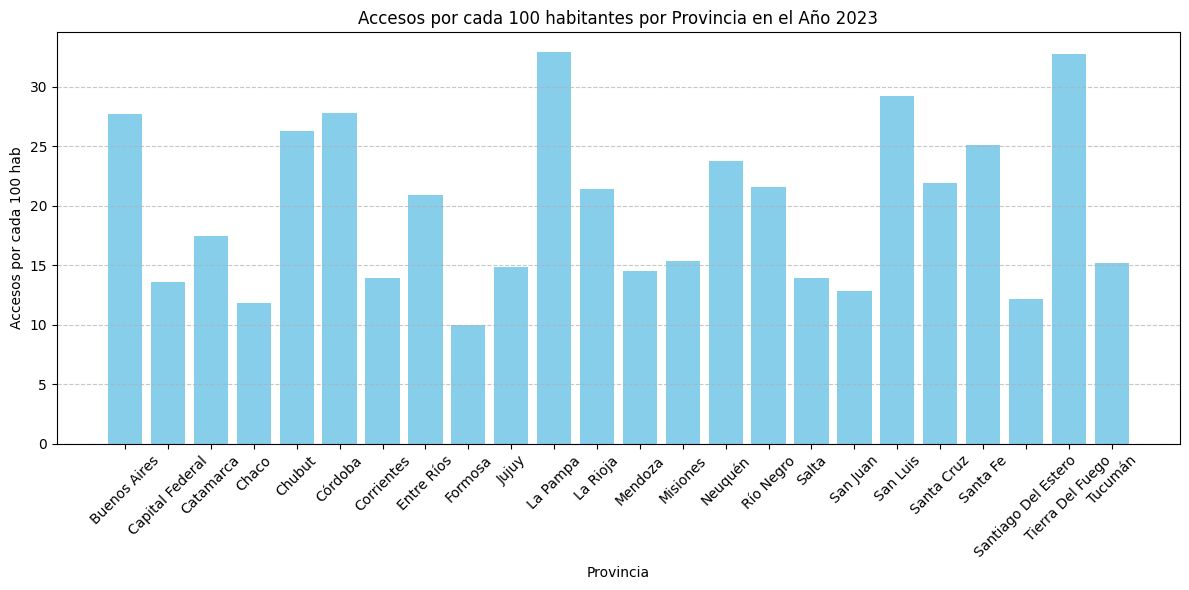

In [22]:
# Filtrar datos para el año 2023
df_filtered = penetracion_poblacion[penetracion_poblacion['Año'] == 2023]

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(df_filtered['Provincia'], df_filtered['Accesos por cada 100 hab'], color='skyblue')

# Añadir etiquetas y ajustar la rotación del eje x
plt.title('Accesos por cada 100 habitantes por Provincia en el Año 2023')
plt.xlabel('Provincia')
plt.ylabel('Accesos por cada 100 hab')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotar etiquetas del eje x
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Veamos la evolución de la penetración de Internet por cada 100 hogares, en las diferentes provincias

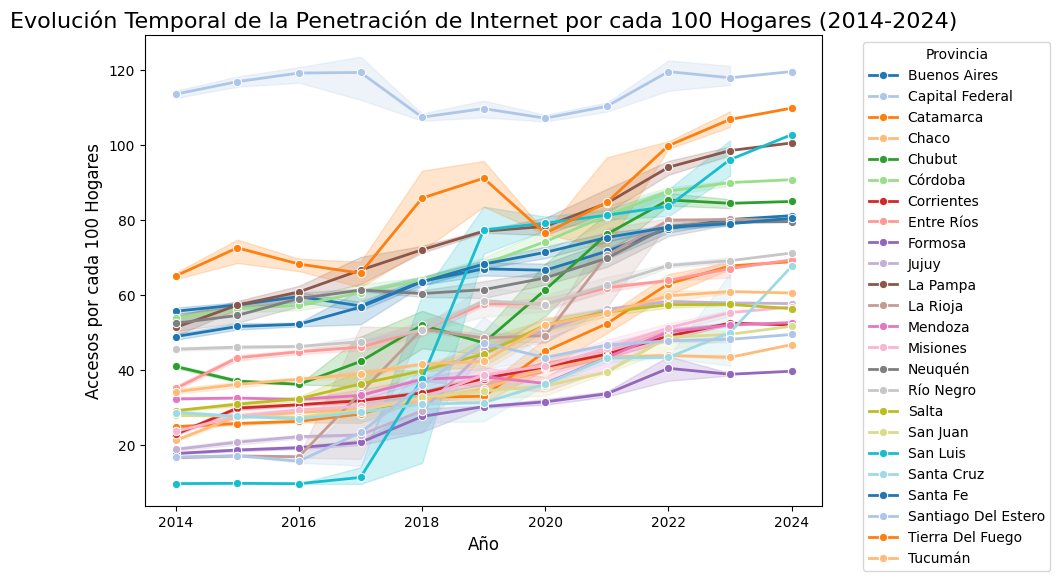

In [23]:
# Crear gráfico de líneas para mostrar la evolución temporal de la penetración de internet por cada 100 hogares
plt.figure(figsize=(10, 6))

# Generar el gráfico de líneas
sns.lineplot(x='Año', y='Accesos por cada 100 hogares', hue='Provincia', data=penetracion_hogares, marker="o", palette='tab20', linewidth=2)

# Personalizar el gráfico
plt.title('Evolución Temporal de la Penetración de Internet por cada 100 Hogares (2014-2024)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Accesos por cada 100 Hogares', fontsize=12)
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda fuera del gráfico

# Mostrar el gráfico
plt.tight_layout()
plt.show()

- Incremento Generalizado de la Penetración de Internet: En la mayoría de las provincias, se observa un incremento constante en la penetración de internet a lo largo de los años. Este aumento refleja el crecimiento de la adopción de tecnologías de internet en los hogares a nivel nacional. Esto sugiere que la demanda de servicios de internet sigue creciendo, lo cual es una oportunidad para que la empresa siga invirtiendo en mejorar la infraestructura y oferta de servicios de internet.
- Diferencias entre Provincias: Hay grandes variaciones en la penetración de internet entre provincias,provincias como Capital Federal y Tierra del Fuego tienen una penetración significativamente mayor que otras como Formosa y Santiago Del Estero. Esto indica áreas donde las provincias más rezagadas, necesitan una mayor inversión en infraestructura para cerrar la brecha digital. La empresa de telecomunicaciones podría priorizar estas regiones para expansión y mejora de los servicios.
- Estancamiento o Descenso en Algunas Provincias: Aunque en la mayoría de las provincias la penetración ha aumentado, en algunas como San Luis y Río Negro, la curva muestra signos de estancamiento o menor crecimiento en los últimos años. Este comportamiento sugiere que, en estas provincias, la empresa podría investigar las causas detrás del estancamiento. Tal vez existan barreras económicas, geográficas o de infraestructura que podrían ser atendidas para reactivar el crecimiento.

Veamos las provincias donde hay menor penetración de Internet por hogar

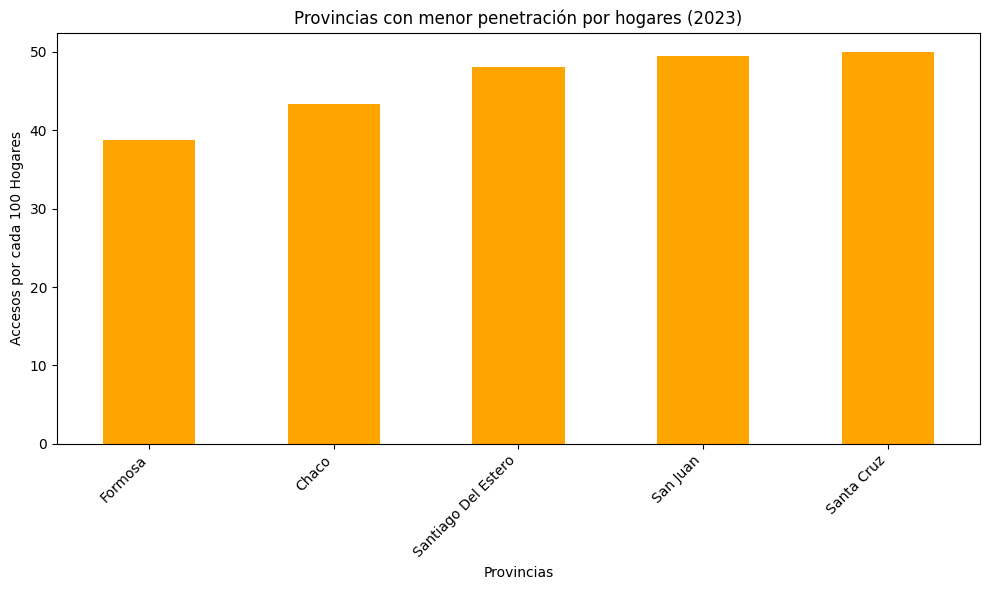

In [24]:
penetracion_2023 = penetracion_hogares[penetracion_hogares['Año'] == 2023]

# Seleccionar las provincias con menor penetración de accesos por cada 100 hogares en el año 2023
provincias_menor_penetracion = penetracion_2023.groupby('Provincia')['Accesos por cada 100 hogares'].mean().sort_values().head(5)

# Graficar las provincias con menor penetración de accesos por cada 100 hogares en 2023
plt.figure(figsize=(10, 6))
provincias_menor_penetracion.plot(kind='bar', color='orange')

# Añadir etiquetas y título
plt.xlabel('Provincias')
plt.ylabel('Accesos por cada 100 Hogares')
plt.title('Provincias con menor penetración por hogares (2023)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar gráfico
plt.show()

Estas provincias representan oportunidades claras para mejorar la infraestructura de telecomunicaciones, ya que tienen un porcentaje de hogares con acceso a internet considerablemente bajo. Esto puede ser un indicativo de barreras económicas, falta de inversión en infraestructura o poca cobertura de redes avanzadas como fibra óptica, además de que también son provincias chicas. 
Por otro lado, esto podría indicar una potencial brecha digital, ya que la baja penetración en estas provincias significa que los ciudadanos en estas áreas pueden estar quedando rezagados en términos de acceso a la educación, servicios, empleo y oportunidades que dependen del acceso a internet. Lo que requiere una acción inmediata de la empresa para mitigar esta brecha.

#### Analicemos la hoja de accesos por Tecnología

Analicemos su evolución.

In [25]:
accesos_por_tecnologia.head()

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2024,1,Buenos Aires,203297.0,2790663.0,1799013.0,150290.0,101294.0,5044557.0
1,2024,1,Capital Federal,70108.0,1177475.0,203756.0,4493.0,48879.0,1504711.0
2,2024,1,Catamarca,5901.0,11025.0,56542.0,1384.0,81.0,74933.0
3,2024,1,Chaco,11343.0,58929.0,64463.0,8404.0,12404.0,155543.0
4,2024,1,Chubut,26306.0,77217.0,26356.0,30867.0,9930.0,170676.0


In [26]:
# Asegúrate de que la columna 'Tecnologias_atrasadas_pct' existe
accesos_por_tecnologia['Tecnologias_atrasadas_pct'] = (
    (accesos_por_tecnologia['ADSL'] + accesos_por_tecnologia['Wireless'] + accesos_por_tecnologia['Otros']) 
    / accesos_por_tecnologia['Total']
) * 100

# Luego puedes filtrar los datos
provincias_mas_atrasadas = accesos_por_tecnologia[accesos_por_tecnologia['Tecnologias_atrasadas_pct'] > 70]

# Mostramos los datos filtrados por script para verificar el filtrado correcto antes de graficar
provincias_mas_atrasadas[['Provincia', 'Tecnologias_atrasadas_pct', 'ADSL', 'Wireless', 'Otros', 'Total']].head()

,Provincia,Tecnologias_atrasadas_pct,ADSL,Wireless,Otros,Total
162,San Luis,75.742607,6860.0,70614.0,14985.0,122070.0
186,San Luis,75.947298,6860.0,70614.0,14985.0,121741.0
209,San Juan,70.805643,34038.0,20723.0,7674.0,88178.0
210,San Luis,90.548546,7987.0,71809.0,28721.0,119844.0
234,San Luis,90.665466,8472.0,70560.0,28723.0,118849.0


veamos cuales son las provincias más atrasadas en el último registro, en cuanto al acceso de tecnología, teniendo en cuenta aquellas que aún usan por ejemplo, ADSL. 

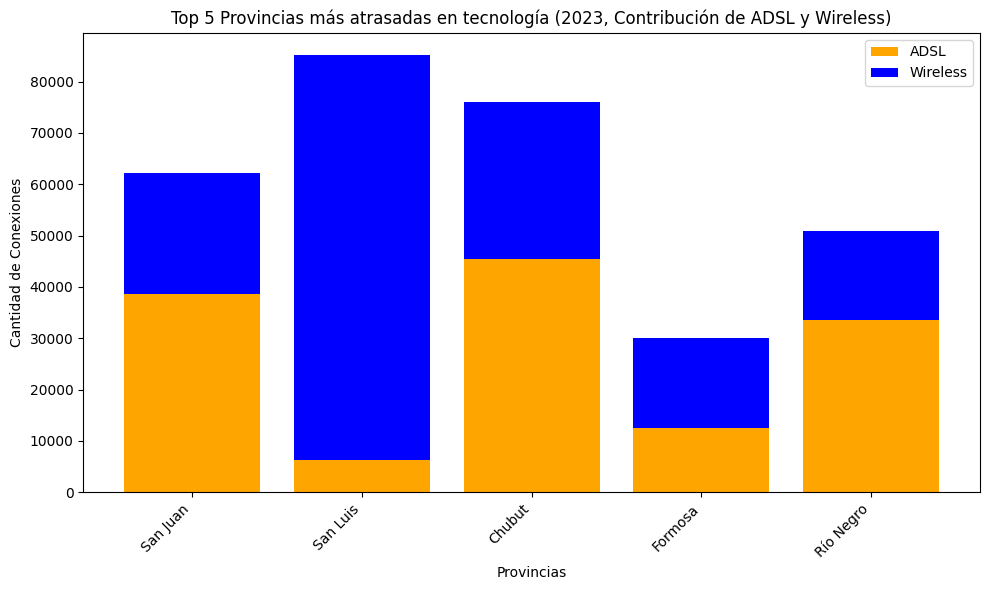

In [27]:
# Filtramos para obtener solo un valor único por provincia, tomando el valor máximo de 'Tecnologias_atrasadas_pct' para cada una
provincias_unicas = accesos_por_tecnologia.groupby('Provincia', as_index=False).max()

# Aplicar un filtro adicional donde las provincias deben tener al menos 10,000 conexiones en ADSL o Wireless
filtro_adsl_wireless = provincias_unicas[
    (provincias_unicas['ADSL'] > 10000) | 
    (provincias_unicas['Wireless'] > 10000)
]

# Aplicar el filtro para seleccionar solo los datos del año 2023
datos_2023 = accesos_por_tecnologia[accesos_por_tecnologia['Año'] == 2023]

# Aplicar el mismo filtro para obtener las provincias más atrasadas, pero solo con datos de 2023
provincias_2023 = datos_2023.groupby('Provincia', as_index=False).max()

# Seleccionamos el nuevo top 5 de provincias más atrasadas basadas en el año 2023
top_5_final_2023 = provincias_2023.sort_values(by='Tecnologias_atrasadas_pct', ascending=False).head(5)

# Crear gráfico de barras apiladas para mostrar la contribución de ADSL y Wireless en cada provincia del top 5 en 2023
plt.figure(figsize=(10, 6))
plt.bar(top_5_final_2023['Provincia'], top_5_final_2023['ADSL'], label='ADSL', color='orange')
plt.bar(top_5_final_2023['Provincia'], top_5_final_2023['Wireless'], bottom=top_5_final_2023['ADSL'], label='Wireless', color='blue')

# Añadir etiquetas y título
plt.xlabel('Provincias')
plt.ylabel('Cantidad de Conexiones')
plt.title('Top 5 Provincias más atrasadas en tecnología (2023, Contribución de ADSL y Wireless)')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

Nos encontramos con que las provincias más atrasadas, dentro del top 5, como se ve son San Juan, San Luis, Chubut, Formosa y Río Negro. Podríamos inferir que es porque son provincias chicas o en gran parte deshabitadas como son los casos de Chubut y Río Negro. De igual manera se podría implementar alguna estrategia para que éstas migren hacia tecnologías más veloces como cablemodem o Fibra óptica

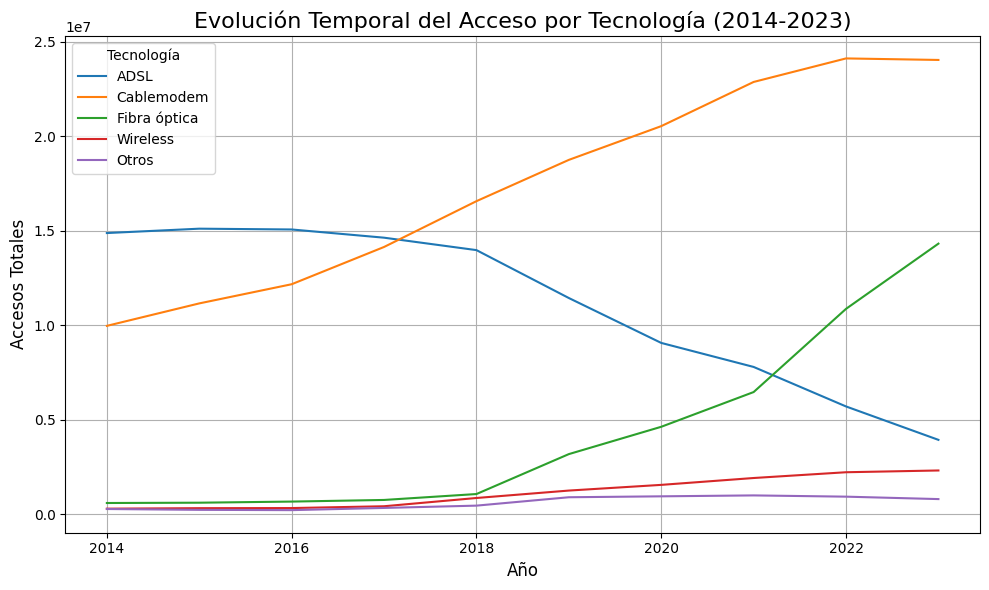

In [28]:
# Filtrar los datos para que solo incluyan los años desde 2014 hasta 2023
data_tecnologia_filtrada = Totales_acc_tecno[(Totales_acc_tecno['Año'] >= 2014) & (Totales_acc_tecno['Año'] <= 2023)]

# Agrupar por año y sumar
data_tecnologia_filtrada = data_tecnologia_filtrada.groupby(['Año']).sum().reset_index()

# Crear el gráfico de evolución temporal por tecnología
plt.figure(figsize=(10, 6))
sns.lineplot(x='Año', y='ADSL', data=data_tecnologia_filtrada, label='ADSL')
sns.lineplot(x='Año', y='Cablemodem', data=data_tecnologia_filtrada, label='Cablemodem')
sns.lineplot(x='Año', y='Fibra óptica', data=data_tecnologia_filtrada, label='Fibra óptica')
sns.lineplot(x='Año', y='Wireless', data=data_tecnologia_filtrada, label='Wireless')
sns.lineplot(x='Año', y='Otros', data=data_tecnologia_filtrada, label='Otros')

plt.title('Evolución Temporal del Acceso por Tecnología (2014-2023)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Accesos Totales', fontsize=12)
plt.legend(title='Tecnología')
plt.grid(True)
plt.tight_layout()

plt.show()

- Migración tecnológica: La evolución muestra una clara migración de tecnologías más antiguas como ADSL hacia tecnologías más rápidas y modernas como Cablemodem y la fibra óptica. Esto está impulsado por la creciente demanda de internet de alta velocidad y la mejora de la infraestructura.
- Transición en el mercado: Aunque Cablemodem sigue siendo relevante, la fibra óptica está ganando rápidamente terreno y podría reemplazarlo como la principal tecnología de acceso en los próximos años.
- Oportunidades para expansión de Fibra Óptica: Dado el incremento sustancial en la adopción de fibra óptica, hay una clara oportunidad para la expansión de esta tecnología, especialmente en áreas urbanas y periurbanas.

Veamos como están los accesos por cada provincia y cuáles tecnologías son las que destacan en ellas. Hagamos una comparación, de acuerdo a los datos disponibles, entre 2014 y 2024. Cómo estabamos y cómo estamos actualmente.

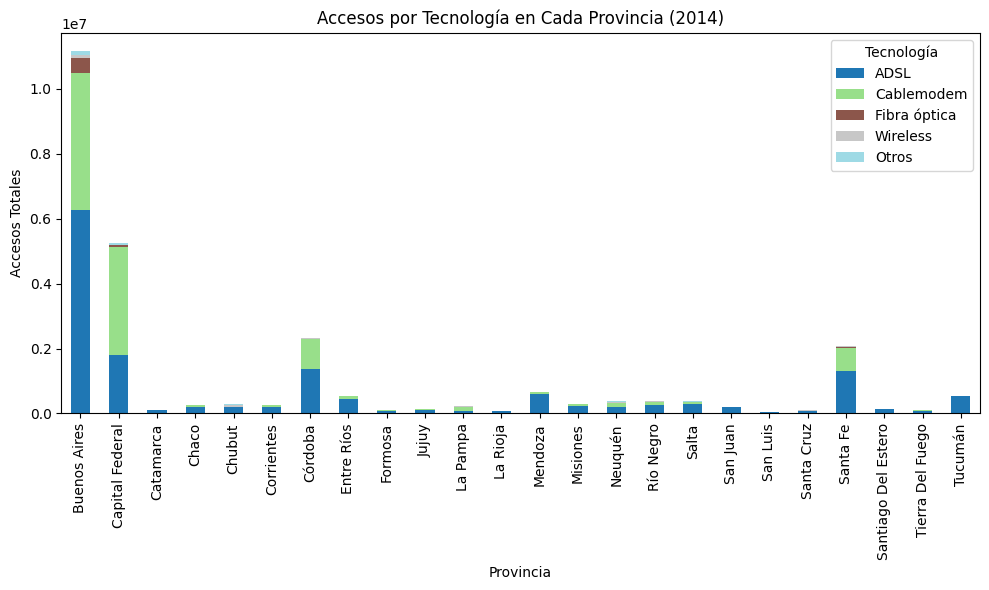

In [29]:
# Filtrar datos para el año 2014
accesos_2014 = accesos_por_tecnologia[accesos_por_tecnologia['Año'] == 2014]

# Agrupar por provincia y sumar los accesos por tecnología
accesos_agrupados = accesos_2014.groupby('Provincia')[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']].sum()

# Crear gráfico de barras apiladas por tecnología
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos agrupados
accesos_agrupados.plot(kind='bar', stacked=True, ax=ax, cmap='tab20')

# Ajustar las etiquetas y el layout
plt.title('Accesos por Tecnología en Cada Provincia (2014)')
plt.ylabel('Accesos Totales')
plt.xlabel('Provincia')
plt.xticks(rotation=90, fontsize=10)  # Reducir el tamaño de las etiquetas
plt.legend(title='Tecnología')
plt.tight_layout()

plt.show()

- Evolución de las Tecnologías: En 2014, el ADSL y el Cablemodem dominaban la mayor parte de los accesos a internet. Para 2024, la Fibra Óptica ha ganado una presencia mucho más significativa, especialmente en provincias como Buenos Aires y Córdoba.
- Desplazamiento de Tecnologías: El Cablemodem sigue siendo fuerte en algunas provincias, pero su participación disminuyó ligeramente en comparación con la Fibra Óptica, que ha mostrado un claro crecimiento.
- Disparidades Regionales: La cantidad de accesos totales sigue concentrada en provincias más pobladas como Buenos Aires, Capital Federal y Córdoba, lo que sugiere que estas áreas continúan siendo prioritarias en términos de acceso tecnológico avanzado.

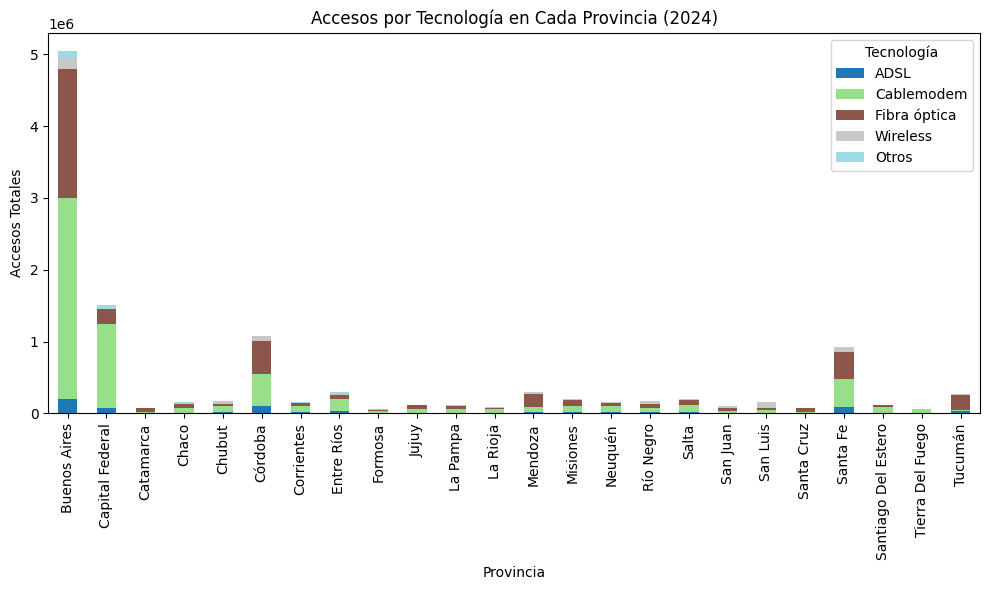

In [30]:
# Filtrar datos para el año 2024
accesos_2024 = accesos_por_tecnologia[accesos_por_tecnologia['Año'] == 2024]

# Crear gráfico de barras apiladas por tecnología
fig, ax = plt.subplots(figsize=(10, 6))
accesos_2024.set_index('Provincia')[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']].plot(kind='bar', stacked=True, ax=ax, cmap='tab20')

plt.title('Accesos por Tecnología en Cada Provincia (2024)')
plt.ylabel('Accesos Totales')
plt.xlabel('Provincia')
plt.xticks(rotation=90)
plt.legend(title='Tecnología')
plt.tight_layout()
plt.show()

- Dominancia de Buenos Aires y Capital Federal: Buenos Aires tiene una cantidad desproporcionadamente mayor de accesos en comparación con las otras provincias, con más de 5 millones de accesos. La mayor parte de estos accesos se realizan mediante Cablemodem y Fibra óptica, lo que sugiere una infraestructura avanzada en esta provincia.
Capital Federal también tiene un número significativamente alto de accesos (alrededor de 1.5 millones), con Cablemodem siendo la tecnología dominante. Esto indica que las grandes áreas metropolitanas tienen mejores infraestructuras y una penetración más alta de tecnologías modernas.

- Adopción de Fibra Óptica: En provincias como Santa Fe y Buenos Aires, la fibra óptica representa una proporción importante del total de accesos, lo que muestra un esfuerzo por modernizar la infraestructura en estas regiones.
Otras provincias, como Chaco y Córdoba, también están adoptando fibra óptica, pero en menor proporción. Esto sugiere que la expansión de esta tecnología está en curso, pero es desigual en todo el país.

- Infraestructura desigual: Provincias como Formosa, Jujuy, La Pampa, y Tierra del Fuego tienen niveles mucho más bajos de accesos a Internet en general, lo que indica una infraestructura menos desarrollada. Estas provincias dependen más de tecnologías como el ADSL, que es una tecnología más antigua en comparación con la fibra óptica o el cablemodem.

- Bajo uso de Wireless: A pesar de que Wireless está disponible, su uso es marginal en casi todas las provincias, con la excepción de algunas provincias más rurales o con acceso limitado a tecnologías de fibra y cablemodem. Esto podría sugerir que, aunque wireless es útil en áreas remotas, no es la opción preferida cuando existen otras tecnologías disponibles.

- Oportunidades de mejora: Provincias como Tucumán, Santiago del Estero, y Santa Cruz podrían beneficiarse de mejoras en la infraestructura tecnológica, dado que su acceso a fibra óptica es limitado. Hay una dependencia continua de tecnologías más antiguas como el Cablemodem o el ADSL.
Las provincias más grandes y urbanizadas están más avanzadas en la adopción de tecnologías modernas, mientras que las provincias más pequeñas y rurales parecen estar rezagadas.

- Perspectiva estratégica: Buenos Aires y Capital Federal están claramente en una posición avanzada en cuanto a penetración tecnológica, pero las oportunidades de crecimiento están en provincias con menos desarrollo tecnológico. Expandir la infraestructura de fibra óptica en estas regiones menos atendidas puede ser una estrategia clave para mejorar la calidad del servicio y ampliar la cobertura.
La baja adopción de Wireless sugiere que, aunque es una tecnología disponible, hay que invertir en tecnologías más estables y confiables como la fibra óptica para mejorar el acceso en las zonas menos conectadas.

Veamos en promedio cuáles son las tecnologías más usadas.

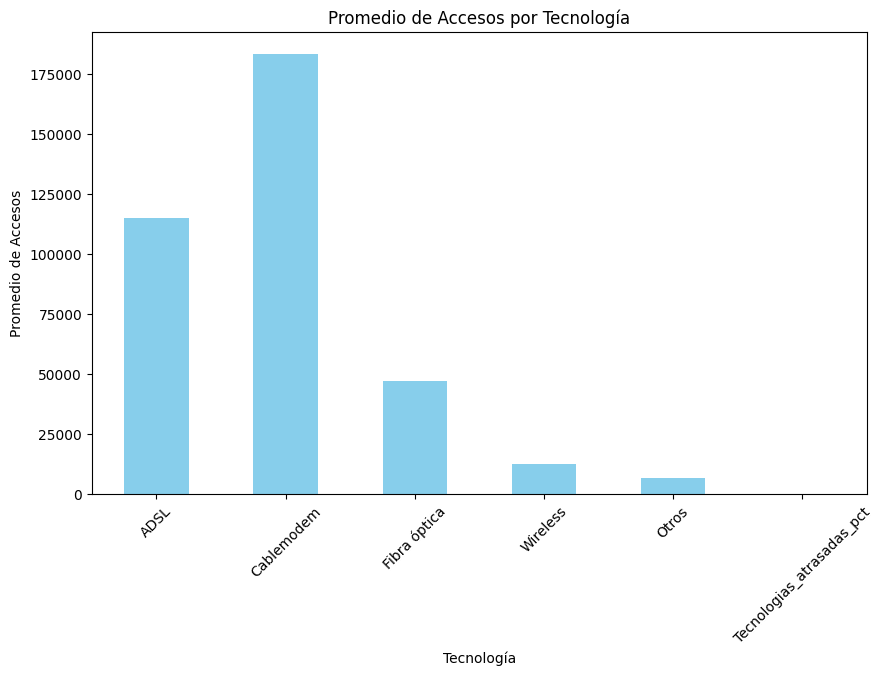

In [31]:
# Eliminar las columnas 'Total', 'Año' y 'Trimestre'
accesos_tecnologia_sin_total = accesos_por_tecnologia.drop(columns=['Total', 'Año', 'Trimestre'])

# Filtrar solo las columnas numéricas después de eliminar 'Total'
accesos_tecnologia_numericas = accesos_tecnologia_sin_total.select_dtypes(include='number')

# Calcular el promedio de accesos por tecnología
promedio_accesos_tecnologia = accesos_tecnologia_numericas.mean()

# Graficar el promedio de accesos por tecnología
plt.figure(figsize=(10, 6))
promedio_accesos_tecnologia.plot(kind='bar', color='skyblue')
plt.title('Promedio de Accesos por Tecnología')
plt.ylabel('Promedio de Accesos')
plt.xlabel('Tecnología')
plt.xticks(rotation=45)
plt.show()

- Dominio de Cablemodem: es claramente la tecnología __más utilizada__, con un promedio de accesos significativamente mayor en comparación con las otras tecnologías. Esto indica que es la opción preferida para muchos hogares en las provincias, probablemente debido a su disponibilidad y costos accesibles en áreas urbanas y suburbanas.

- Uso considerable de ADSL: ADSL sigue siendo una tecnología importante, aunque es menos avanzada que el Cablemodem o la fibra óptica. Su adopción es aún notable, lo que sugiere que en ciertas áreas, __donde la infraestructura más moderna no está disponible__, los usuarios dependen de ADSL.

- Crecimiento de la Fibra Óptica: Muestra un buen promedio de accesos, lo que __refleja la modernización gradual__ de la infraestructura tecnológica en las provincias. Aunque no alcanza los niveles de Cablemodem o ADSL, se espera que siga creciendo en el futuro, especialmente en áreas urbanas más desarrolladas.

- Wireless y Otros: Tienen un promedio de accesos bastante bajo en comparación con las otras tecnologías. Esto sugiere que estas tecnologías son __más utilizadas en áreas rurales o en situaciones donde las opciones más robustas no están disponibles.__ Wireless podría estar en uso en regiones remotas o difíciles de acceder, mientras que 'Otros' podría incluir tecnologías más antiguas o alternativas de menor escala.

Implicaciones:
- Expansión de la Fibra Óptica: A medida que las áreas urbanas continúan desarrollándose, se puede anticipar que __la fibra óptica reemplazará en gran medida al ADSL y competirá con el Cablemodem__ como la tecnología de acceso principal. Invertir en la expansión de esta tecnología sería estratégico para mejorar la calidad y velocidad del servicio.
- Actualización de Infraestructuras: __El uso persistente de ADSL indica que ciertas áreas aún dependen de tecnologías más antiguas.__ Estas zonas podrían ser objetivos para la actualización a tecnologías más modernas, lo que mejoraría tanto la velocidad como la confiabilidad del servicio.
- Oportunidades en Regiones Rurales: Dado el bajo uso de Wireless y otras tecnologías, parece haber una oportunidad de crecimiento en las áreas rurales que carecen de acceso a infraestructuras más avanzadas. Ampliar el acceso a través de tecnologías más robustas podría mejorar el servicio y abrir nuevos mercados en estas áreas menos desarrolladas.

#### Veamos la hoja de accesos por velocidad

In [32]:
acc_por_velocidad.head()

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
0,2024,1,Buenos Aires,26002.0,22510.0,221185.0,233225.0,241778.0,106418.0,4068292.0,125147.0,5044557.0
1,2024,1,Capital Federal,516.0,5418.0,29753.0,51415.0,37369.0,5957.0,1374283.0,0.0,1504711.0
2,2024,1,Catamarca,71.0,176.0,2872.0,3424.0,4204.0,1822.0,62294.0,70.0,74933.0
3,2024,1,Chaco,236.0,416.0,14156.0,9044.0,5533.0,5718.0,116624.0,3816.0,155543.0
4,2024,1,Chubut,111.0,1083.0,43828.0,31885.0,23024.0,20261.0,33844.0,16640.0,170676.0


De acuerdo al primer análisis de las hojas, nos percatabamos de que teníamos nulos en la columna otros.

In [33]:
acc_por_velocidad.isnull().sum()

Año                    0
Trimestre              0
Provincia              0
HASTA 512 kbps         0
+ 512 Kbps - 1 Mbps    0
+ 1 Mbps - 6 Mbps      0
+ 6 Mbps - 10 Mbps     0
+ 10 Mbps - 20 Mbps    0
+ 20 Mbps - 30 Mbps    0
+ 30 Mbps              0
OTROS                  6
Total                  0
dtype: int64

In [34]:
# Reemplazar los valores nulos por cero en OTROS
acc_por_velocidad['OTROS'].fillna(0, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\44995802.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  acc_por_velocidad['OTROS'].fillna(0, inplace=True)


Veamos como es la distribución de velocidades por provincias, desde las velocidades más bajas (512 kbps) hasta las velocidades más altas (+30 mbps)

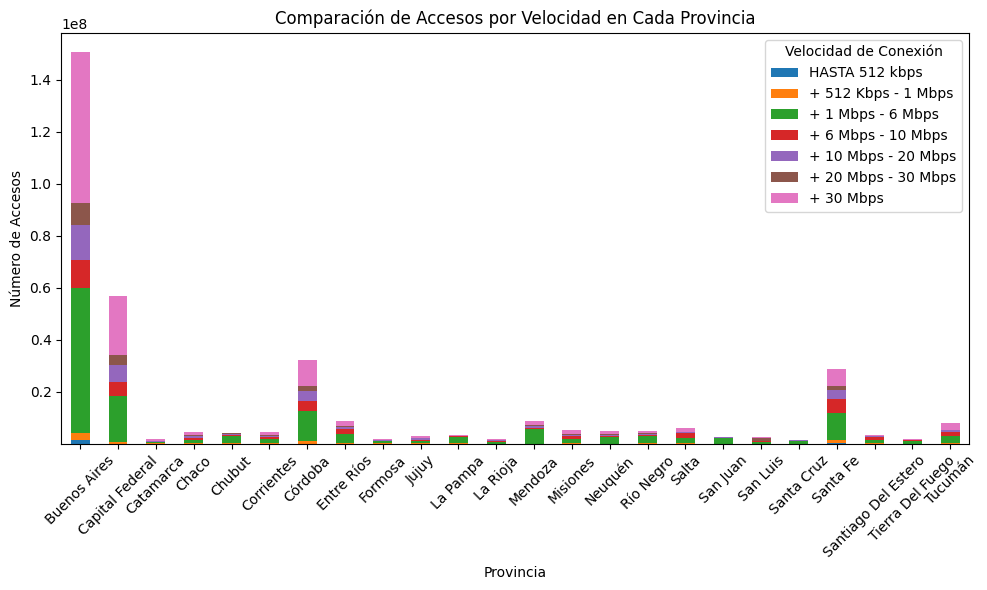

In [35]:
# 1. Comparación de Velocidades por Provincia
# Seleccionamos las columnas relevantes para comparar velocidades por provincia
velocidades_columns = ['Provincia', 'HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps', '+ 6 Mbps - 10 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps', '+ 30 Mbps']

# Agrupamos por provincia y sumamos los accesos
velocidades_provincia = acc_por_velocidad.groupby('Provincia')[velocidades_columns[1:]].sum()

# Gráfico de comparación de velocidades por provincia
velocidades_provincia.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Comparación de Accesos por Velocidad en Cada Provincia')
plt.ylabel('Número de Accesos')
plt.xlabel('Provincia')
plt.legend(title='Velocidad de Conexión')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Desigualdad en el Acceso a Internet:
Buenos Aires y Capital Federal dominan de manera abrumadora en términos de accesos a internet en todas las velocidades, especialmente en conexiones de más de 30 Mbps.
En contraste, provincias como Santiago del Estero, Chaco, La Rioja, Formosa y otras tienen una presencia muy limitada en accesos de alta velocidad, lo cual indica una gran disparidad en la infraestructura de internet entre provincias.
__Hay una necesidad de Mejorar la Infraestructura de Alta Velocidad__, las conexiones de más de 30 Mbps dominan en Buenos Aires, Capital Federal, Córdoba, y Santa Fe, lo que sugiere que hay una demanda considerable por internet de alta velocidad en estas áreas. La empresa podría continuar invirtiendo en fibras ópticas y tecnologías de alta capacidad en estas zonas urbanas.
En provincias con menor infraestructura, la empresa debe analizar la viabilidad de expandir redes de fibra óptica y tecnología de alta velocidad para captar un nuevo mercado de consumidores.
__Disminuir la Dependencia en Conexiones Lentas__, aunque la tendencia general es hacia velocidades más altas, todavía hay una dependencia significativa de las conexiones lentas (hasta 512 kbps) en algunas provincias. Esto podría indicar que ciertas regiones aún dependen de tecnologías antiguas como ADSL o conexiones de baja calidad. Se recomienda comenzar un proceso de transición y modernización de las redes en estas áreas para reducir la brecha digital y mejorar la experiencia del usuario.

- Oportunidades de Crecimiento en Provincias con Baja Conectividad:
La empresa podría enfocarse en mejorar la infraestructura en provincias como Catamarca, Santiago del Estero, Formosa, y La Rioja, donde la penetración de internet de alta velocidad es baja. Estas provincias podrían representar una oportunidad de crecimiento para la compañía si se invierte en aumentar la capacidad de acceso a velocidades más altas.
Se recomienda realizar estudios de mercado para identificar las demandas específicas de estos lugares y ofrecer paquetes personalizados que fomenten el aumento de suscriptores a internet de mayor velocidad.

- Estrategias de Diferenciación por Región:
Cada región parece tener una distribución diferente de velocidades, lo que sugiere que la empresa debería diferenciar su estrategia según la provincia. En áreas urbanas con alta penetración de internet rápido, se podrían ofrecer servicios premium, mientras que en regiones más rezagadas, podrían ofrecerse paquetes accesibles con planes para mejorar progresivamente la velocidad de acceso.

- Planes de Expansión de Redes Inalámbricas:
Las conexiones inalámbricas (Wireless) también parecen estar presentes en varias provincias, lo que sugiere que la empresa podría expandir redes inalámbricas en áreas donde la infraestructura cableada es difícil de instalar.

__La empresa puede aprovechar estas observaciones para ajustar su estrategia de expansión, enfocándose en la mejora de la infraestructura en provincias rezagadas y consolidando su dominio en las áreas más desarrolladas. Además, podría desarrollar planes de transición tecnológica en las provincias que aún dependen de conexiones lentas y antiguas. Además se podría consdierar priorizar inversiones en regiones que tengan una mayor demanda latente de internet de alta velocidad__

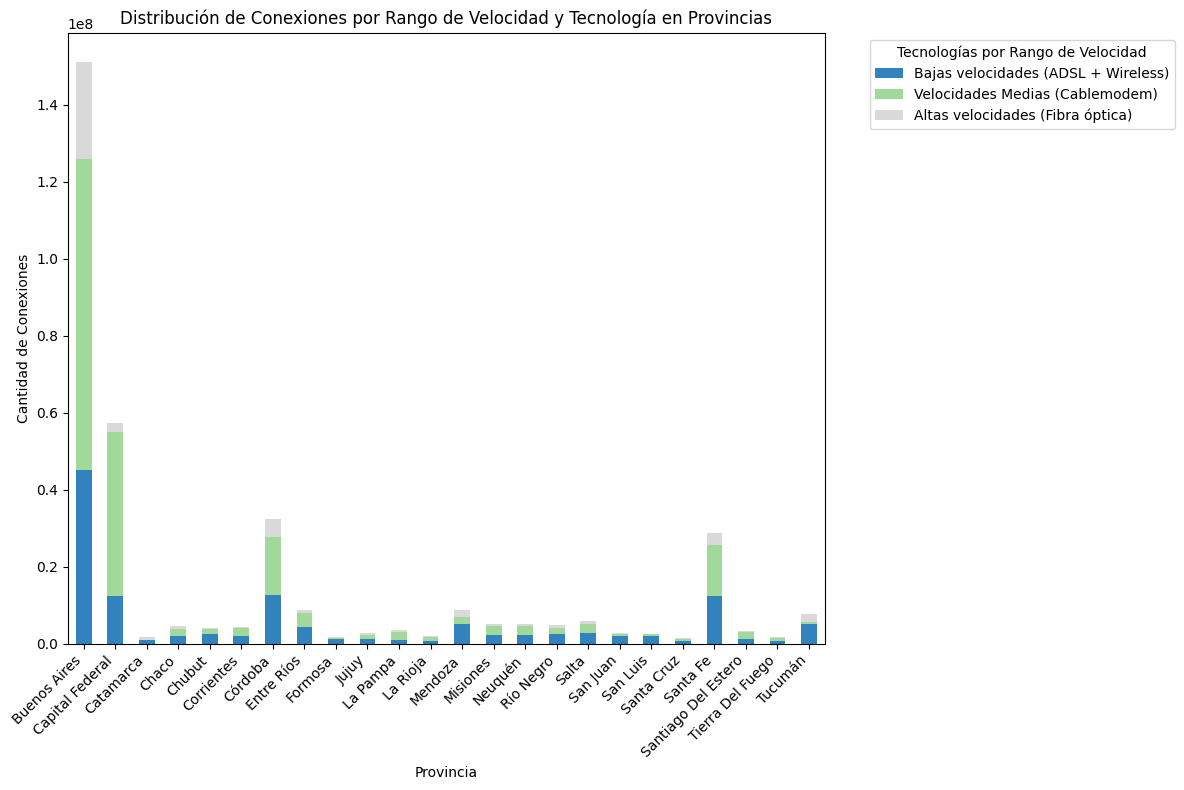

In [36]:
# Unimos los DataFrames basados en las columnas comunes: Año, Trimestre y Provincia
accesos_combinado = pd.merge(accesos_por_tecnologia, acc_por_velocidad, on=['Año', 'Trimestre', 'Provincia'])

# Sumamos los accesos por tecnología en cada provincia
tecnologias_por_provincia = accesos_por_tecnologia.groupby('Provincia')[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless']].sum()

# Sumamos los accesos por velocidad en cada provincia
velocidades_por_provincia = acc_por_velocidad.groupby('Provincia').sum()

# Normalizamos ambas tablas para que tengan los mismos índices
data_combinada = pd.concat([tecnologias_por_provincia, velocidades_por_provincia], axis=1, join='inner')

# Creamos nuevas columnas asignando los rangos de velocidad a las tecnologías
data_combinada['Rango_ADSL'] = 'Bajas velocidades (Hasta 10 Mbps)'
data_combinada['Rango_Wireless'] = 'Bajas velocidades (Hasta 10 Mbps)'
data_combinada['Rango_Cablemodem'] = 'Velocidades Medias (10 Mbps - 30 Mbps)'
data_combinada['Rango_Fibra_Optica'] = 'Altas velocidades (Más de 30 Mbps)'

# Crear un gráfico más representativo separando las tecnologías por rangos de velocidad (bajas, medias, altas)
# Combinaremos los rangos y tecnologías para representar mejor las oportunidades de mejora en cada provincia

# Reorganizamos los datos para mostrar la cantidad de conexiones en cada rango de velocidad por tecnología
rango_tecnologias_representativo = pd.DataFrame({
    'Bajas velocidades (ADSL + Wireless)': data_combinada['ADSL'] + data_combinada['Wireless'],
    'Velocidades Medias (Cablemodem)': data_combinada['Cablemodem'],
    'Altas velocidades (Fibra óptica)': data_combinada['Fibra óptica']
})

# Crear gráfico de barras apiladas más representativo
rango_tecnologias_representativo.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20c')

# Añadir etiquetas y título
plt.title('Distribución de Conexiones por Rango de Velocidad y Tecnología en Provincias')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de Conexiones')
plt.legend(title='Tecnologías por Rango de Velocidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar gráfico
plt.show()

En base a lo que obtuvimos, profundicemos un poco más en las provincias que tienen acceso a una velocidad lenta de Internet

                 HASTA 512 kbps  + 512 Kbps - 1 Mbps  Total Lentas
Provincia                                                         
Buenos Aires         1449330.84            2694282.0    4143612.84
Santa Fe              115482.00            1434741.0    1550223.00
Córdoba                11569.00            1214000.0    1225569.00
Capital Federal        32052.16             762534.0     794586.16
Entre Ríos             39683.00             420149.0     459832.00
Tucumán                 2264.00             368832.0     371096.00
La Pampa               48359.00             213368.0     261727.00
Corrientes              1697.00             236866.0     238563.00
Salta                  15444.00             209579.0     225023.00
Misiones               16519.00             205019.0     221538.00


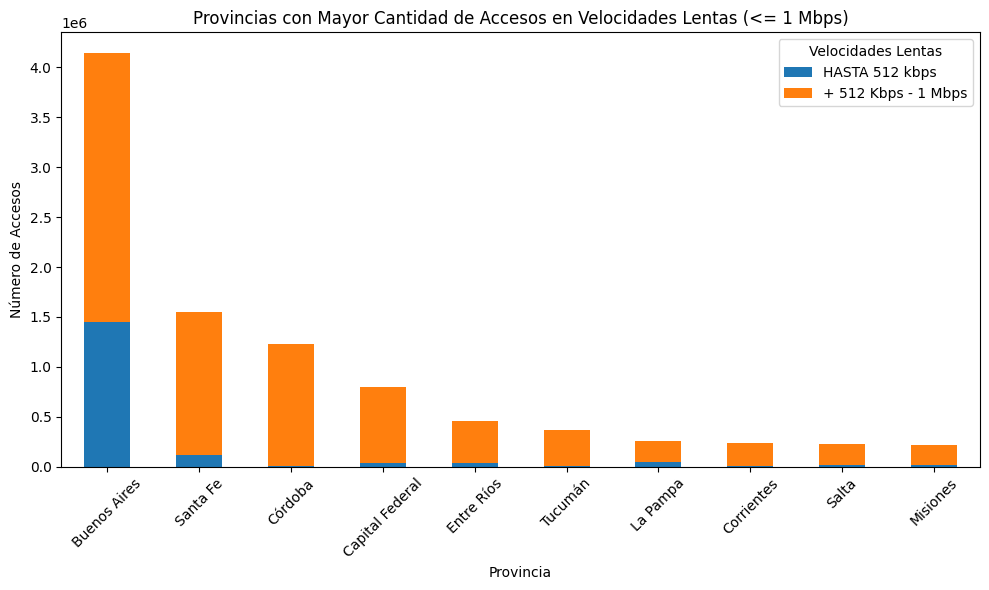

In [37]:
# Seleccionamos las columnas relevantes para identificar las velocidades más lentas
velocidades_lentas_columns = ['Provincia', 'HASTA 512 kbps', '+ 512 Kbps - 1 Mbps']

# Agrupamos por provincia y sumamos los accesos a las velocidades más lentas
velocidades_lentas = acc_por_velocidad.groupby('Provincia')[velocidades_lentas_columns[1:]].sum()

# Calculamos el total de accesos lentos por provincia (suma de las dos velocidades más lentas)
velocidades_lentas['Total Lentas'] = velocidades_lentas['HASTA 512 kbps'] + velocidades_lentas['+ 512 Kbps - 1 Mbps']

# Ordenamos las provincias por las velocidades más lentas
velocidades_lentas_ordenadas = velocidades_lentas.sort_values(by='Total Lentas', ascending=False)

# Filtramos las provincias con mayores accesos en velocidades lentas
provincias_lentas_top = velocidades_lentas_ordenadas.head(10)  # Muestra las 10 provincias con más accesos lentos

# Mostramos el resultado
print(provincias_lentas_top)

# Gráfico de las provincias con más accesos en velocidades lentas
provincias_lentas_top[['HASTA 512 kbps', '+ 512 Kbps - 1 Mbps']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Provincias con Mayor Cantidad de Accesos en Velocidades Lentas (<= 1 Mbps)')
plt.ylabel('Número de Accesos')
plt.xlabel('Provincia')
plt.xticks(rotation=45)
plt.legend(title='Velocidades Lentas')
plt.tight_layout()
plt.show()

- Provincia de Buenos Aires:
Tiene, por mucho, la mayor cantidad de accesos en velocidades lentas. Gran parte de los accesos están en el rango de + 512 Kbps - 1 Mbps (naranja), aunque también hay un número considerable en la categoría HASTA 512 kbps (azul).
Esto indica que, aunque Buenos Aires es la provincia más desarrollada en términos de conectividad, también tiene una gran cantidad de conexiones lentas que podrían mejorarse. Es una oportunidad para actualizar la infraestructura y mejorar el servicio.
__Se podrían hacer esfuerzos para modernizar la infraestructura, especialmente en áreas con accesos de menos de 1 Mbps.__

- Santa Fe, Córdoba y Capital Federal:
Estas provincias y la Ciudad Autónoma también muestran una cantidad significativa de accesos en velocidades lentas, pero mucho menor en comparación con Buenos Aires. La mayoría de las conexiones lentas en estas provincias están en el rango de + 512 Kbps - 1 Mbps.
Aquí también hay espacio para mejoras, especialmente en áreas rurales o menos desarrolladas dentro de éstas.
__Las mismas deberían estar en el radar para futuras actualizaciones de la red, presentar oportunidad para mejorar la calidad del servicio.__

- Otras Provincias (Entre Ríos, Tucumán, etc.):
Las provincias como Entre Ríos, Tucumán, La Pampa, Corrientes, Salta, y Misiones tienen un menor número de accesos en velocidades lentas, pero aún están presentes. Éstas muestran menos conexiones en el rango más lento (HASTA 512 kbps).
Aunque los números son menores, podría ser estratégico enfocar esfuerzos en mejorar las infraestructuras en ellas para igualar las velocidades de conexión con provincias más avanzadas.
__Las provincias más pequeñas o menos desarrolladas también deberían ser parte de una estrategia de mejora, ya que reducir las conexiones lentas puede generar una mayor adopción de servicios de mayor velocidad.__

Vamos a identificar provincias donde la penetración de internet es alta o baja en relación con la cantidad de accesos totales. Esto puede ayudar a la empresa a comprender qué regiones ya están bien servidas y cuáles podrían necesitar más infraestructura.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\2218802406.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(penetracion_vs_accesos['Accesos por cada 100 hogares'][i],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\2218802406.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  penetracion_vs_accesos['Total'][i],


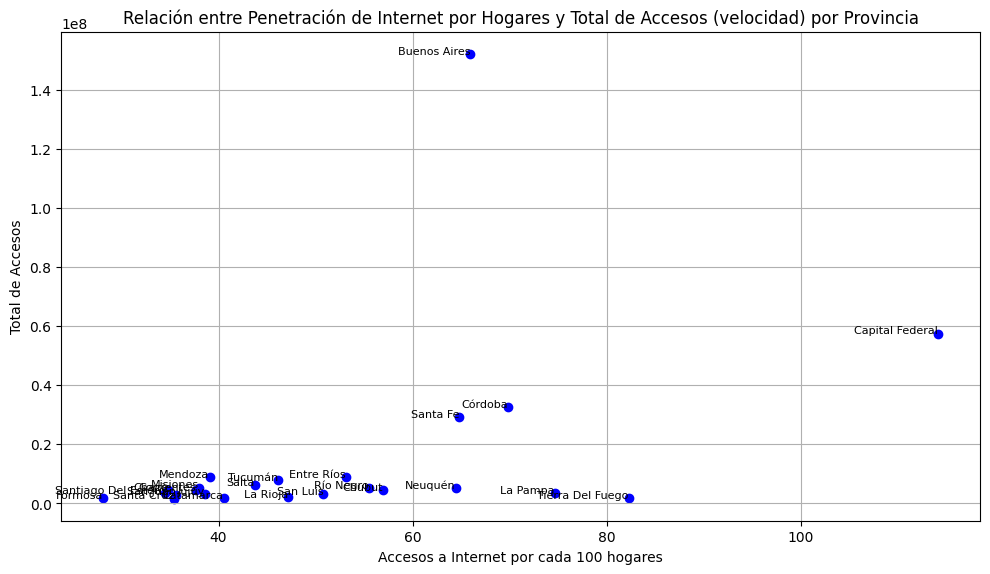

In [38]:
# 2. Relación entre Accesos y Penetración por Hogares
# Unimos los datos de penetración con los de accesos por provincia
penetracion_hogares_grouped = penetracion_hogares.groupby('Provincia').mean()
total_accesos_provincia = acc_por_velocidad.groupby('Provincia')['Total'].sum()

# Creamos un DataFrame combinado
penetracion_vs_accesos = pd.concat([total_accesos_provincia, penetracion_hogares_grouped['Accesos por cada 100 hogares']], axis=1).dropna()

plt.figure(figsize=(10, 6))
plt.scatter(penetracion_vs_accesos['Accesos por cada 100 hogares'], penetracion_vs_accesos['Total'], color='blue')

# Añadir etiquetas de provincias
for i, province in enumerate(penetracion_vs_accesos.index):
    plt.text(penetracion_vs_accesos['Accesos por cada 100 hogares'][i], 
             penetracion_vs_accesos['Total'][i], 
             province, fontsize=8, ha='right')

plt.title('Relación entre Penetración de Internet por Hogares y Total de Accesos (velocidad) por Provincia')
plt.xlabel('Accesos a Internet por cada 100 hogares')
plt.ylabel('Total de Accesos')
plt.grid(True)
plt.tight_layout()
plt.show()

- Capital Federal y Buenos Aires destacan:
Capital Federal tiene una __penetración muy alta de internet por hogar (alrededor de 100 accesos por cada 100 hogares)__, lo que sugiere que casi todos los hogares tienen acceso a internet. Sin embargo, su total de accesos es menor en comparación con Buenos Aires. Aunque Capital Federal muestra una alta penetración, __parece haber espacio para incrementar los accesos totales.__
Buenos Aires, por otro lado, tiene un enorme número de accesos totales, con alrededor de 1.4e8 accesos, pero su penetración por hogar es mucho menor que la de Capital Federal, indicando que __aunque hay muchos accesos, no están tan bien distribuidos en los hogares.__. Buenos Aires debería enfocarse en mejorar la distribución del acceso a internet por hogar, ya que tiene una cantidad considerable de accesos, pero no está tan bien distribuido entre los hogares.

- Santa Fe y Córdoba:
Ambas provincias están en una __zona intermedia en términos de total de accesos__, con valores más bajos que Buenos Aires pero superiores a muchas otras provincias.
Sin embargo, __su penetración de internet por hogares es relativamente baja__ en comparación con Capital Federal y otras provincias con menor población.
Estas provincias tienen potencial de crecimiento tanto en penetración como en el total de accesos. Una estrategia podría ser aumentar la infraestructura en estas áreas para mejorar la penetración y aprovechar su tamaño poblacional.

- Provincias con baja penetración y bajos accesos:
Provincias como Santiago del Estero, Salta, San Juan, Formosa y La Rioja __muestran tanto baja penetración de internet por hogar (menos de 50 accesos por cada 100 hogares) como bajo total de accesos__. Esto indica que son regiones que podrían estar experimentando una menor cobertura o capacidad de infraestructura.
En estas áreas, la empresa debería enfocar sus esfuerzos en mejorar la infraestructura de telecomunicaciones, ya que tanto la penetración por hogar como los accesos totales son bajos. Estas provincias podrían representar oportunidades de crecimiento si se mejora la conectividad.

- Provincias con buena penetración, pero bajos accesos:
La Pampa y Tierra del Fuego muestran una __penetración relativamente buena (cerca de 80 accesos por cada 100 hogares), pero sus totales de acceso son muy bajos__. Esto podría sugerir que aunque una proporción significativa de la población tiene acceso a internet, el número total de usuarios es bajo debido a la baja densidad poblacional.
Para éstas, la empresa podría considerar estrategias de expansión de mercado, ya que aunque la penetración es buena, el número total de accesos sigue siendo bajo. Una posible estrategia es promover el uso de servicios de internet en estas regiones menos pobladas.

#### Analizamos la hoja Dial_Baf (Accesos dial-up y Banda Ancha Fija (BAf).)
Representa los datos de los accesos a los mismos

In [39]:
Dial_BAf.head()

,Año,Trimestre,Provincia,Banda ancha fija,Dial up,Total
0,2024,1,Buenos Aires,5038657,5900.0,5044557
1,2024,1,Capital Federal,1502661,2050.0,1504711
2,2024,1,Catamarca,74932,1.0,74933
3,2024,1,Chaco,155538,5.0,155543
4,2024,1,Chubut,169819,857.0,170676


Veamos el panorama general de las tecnologías

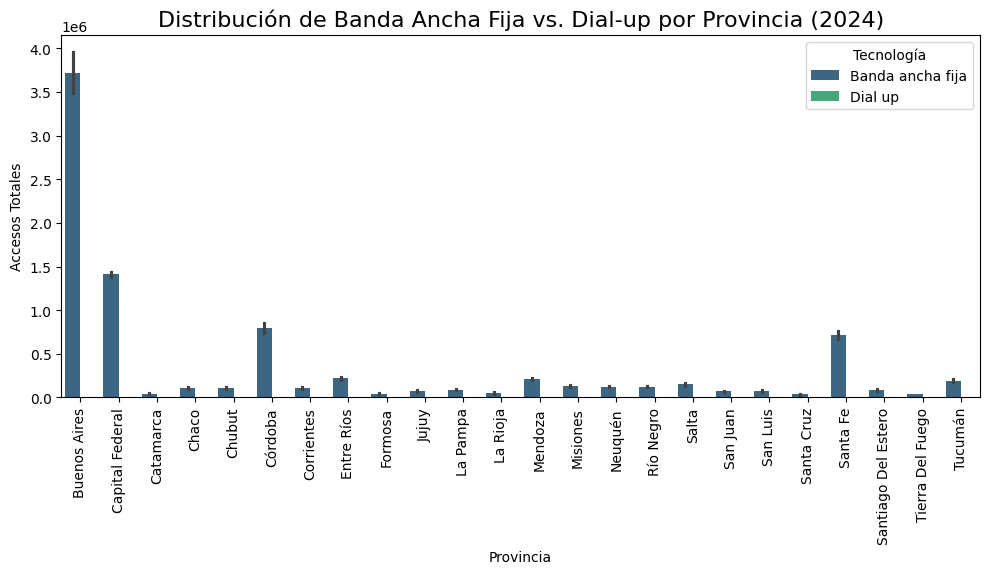

In [40]:
# Crear un DataFrame para la comparación de Banda Ancha vs. Dial-up por provincia
Dial_BAF_long = pd.melt(Dial_BAf, id_vars=['Provincia'], value_vars=['Banda ancha fija', 'Dial up'], 
                        var_name='Tecnología', value_name='Accesos')

# Crear un gráfico de barras apiladas para visualizar la comparación
plt.figure(figsize=(10, 6))
sns.barplot(data=Dial_BAF_long, x='Provincia', y='Accesos', hue='Tecnología', palette='viridis')
plt.title('Distribución de Banda Ancha Fija vs. Dial-up por Provincia (2024)', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Accesos Totales')
plt.xlabel('Provincia')
plt.legend(title='Tecnología')
plt.tight_layout()
plt.show()

- Banda Ancha Dominante: Buenos Aires y Capital Federal tienen una gran cantidad de accesos a Banda Ancha Fija en comparación con otras provincias. Santa Fe y Córdoba también destacan.
- Dial-up Marginal: El uso de Dial-up es insignificante en comparación con Banda Ancha Fija en la mayoría de las provincias, siendo más visible en algunas provincias, pero sigue siendo minoritario.
__Se refleja la adopción casi total de banda ancha fija en las provincias más desarrolladas__

Veamos los accesos a banda ancha fija por provincia.

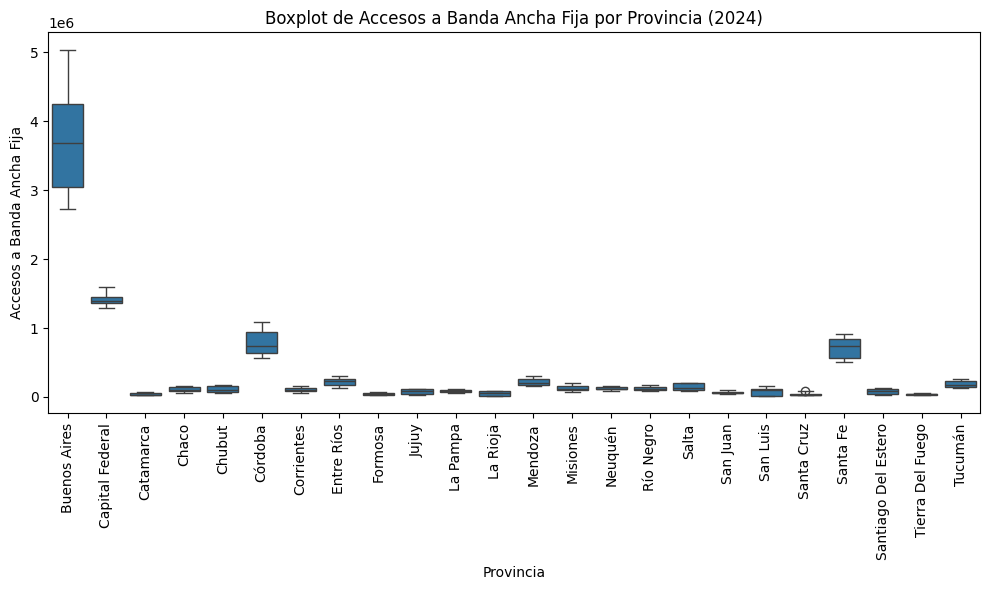

In [41]:
# Fusionar los dataframes en función de 'Provincia' y 'Año'
df_combined = pd.merge(Dial_BAf, penetracion_hogares, on=['Provincia', 'Año', 'Trimestre'])

# Graficar un boxplot para identificar outliers en el acceso a Banda Ancha Fija por provincia
plt.figure(figsize=(10, 6))
sns.boxplot(x='Provincia', y='Banda ancha fija', data=df_combined)
plt.xticks(rotation=90)
plt.title('Boxplot de Accesos a Banda Ancha Fija por Provincia (2024)')
plt.ylabel('Accesos a Banda Ancha Fija')
plt.xlabel('Provincia')
plt.tight_layout()

plt.show()

- Distribución por Provincia: El boxplot proporciona una visión clara de cómo se distribuyen los accesos a banda ancha fija. Las provincias como Buenos Aires, Capital Federal, Córdoba y Santa Fe destacan por tener un número mucho mayor de accesos en comparación con otras provincias, lo que sugiere que estas son las regiones más desarrolladas en términos de conectividad como veíamos anteriormente.

- Identificación de Outliers: El gráfico muestra claramente provincias como las anteriormente mencionadas que tienen una gran cantidad de accesos, mientras que otras provincias tienen valores mucho menores. Esto indica una alta concentración de accesos en ciertas áreas, lo que puede sugerir desigualdades en la infraestructura de telecomunicaciones.

- Rango y Variabilidad: El gráfico destaca las variaciones en el acceso a banda ancha fija dentro de las provincias. Por ejemplo, Buenos Aires tiene una mayor variabilidad en la cantidad de accesos, mientras que provincias como Santiago del Estero o Tierra del Fuego muestran menos variabilidad. Esto puede indicar que algunas provincias tienen un mercado más heterogéneo en términos de acceso a banda ancha, mientras que otras tienen una penetración más uniforme.

- Oportunidades de Expansión: Las provincias con menor cantidad de accesos representan áreas potenciales de crecimiento para la empresa. Regiones con un bajo número de accesos y baja variabilidad sugieren que la penetración de banda ancha aún no ha alcanzado su máximo potencial, y la empresa podría capitalizar estas oportunidades mediante inversiones estratégicas en infraestructura.

__Conclusiones que Podemos Extraer:__
- Foco en Buenos Aires y Capital Federal: Estas provincias tienen la mayor cantidad de accesos a banda ancha fija, pero también presentan una mayor variabilidad. Esto sugiere que aún hay segmentos de mercado sin explotar dentro de estas regiones que la empresa podría abordar.
- Regiones Desatendidas: Provincias como Formosa, Jujuy y La Rioja tienen una baja cantidad de accesos, lo que podría indicar una infraestructura insuficiente o falta de penetración del servicio. Estas provincias representan una oportunidad para que la empresa amplíe su infraestructura y aumente su base de clientes.
- Planificación de Recursos: Las provincias con menor cantidad de accesos pero alta variabilidad (como Santa Cruz) pueden ser puntos de interés para mejorar o expandir la infraestructura existente.

Si consideramos que la __banda ancha__ se refiere, a cualquier red que permite la transmisión de datos a gran velocidad, donde se incluye entre otras la fibra óptica, la banda ancha móvil o el servicio de conexión por cable o ADSL. Los servicios de banda estrecha como el __dial-up__, las cuales utilizan un aparato denominado módem o modulador/demodulador, tienen velocidades bajas. Por lo que sería interesante ver si la tecnología persiste en alguna de las provincias

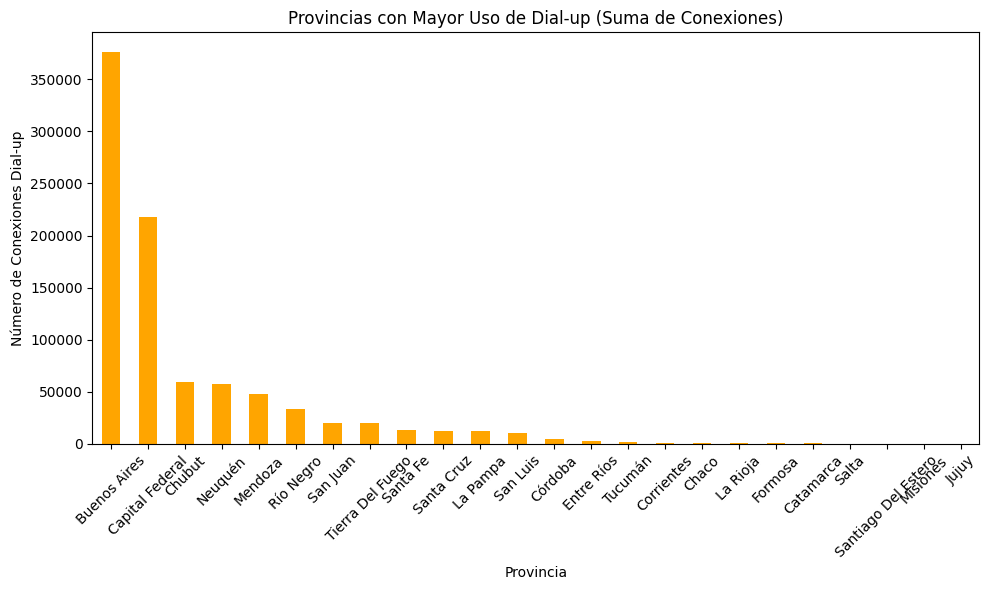

In [42]:
# Filtrar las provincias con uso persistente de Dial-up en los últimos años
uso_dialup_persistente = Dial_BAf[Dial_BAf['Dial up'] > 0].groupby('Provincia')['Dial up'].sum().sort_values(ascending=False)

# Graficar las provincias con mayor uso de Dial-up
plt.figure(figsize=(10, 6))
uso_dialup_persistente.plot(kind='bar', color='orange')
plt.title('Provincias con Mayor Uso de Dial-up (Suma de Conexiones)')
plt.ylabel('Número de Conexiones Dial-up')
plt.xlabel('Provincia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Concentración del Uso de Dial-up:
Buenos Aires y Capital Federal destacan como las provincias con el mayor número de conexiones Dial-up. Estas son, de lejos, las que más conexiones Dial-up mantienen, lo que podría deberse a la alta densidad de población y la presencia de áreas donde la infraestructura de banda ancha no ha sido implementada o donde el acceso a tecnologías más avanzadas es limitado.

- Uso Residual de Dial-up:
Provincias como Neuquén, Mendoza, Río Negro, y San Juan aún tienen un número significativo de conexiones Dial-up, lo que sugiere que existen áreas donde la transición hacia tecnologías de banda ancha más modernas no ha sido completa.
Las provincias más alejadas, con menor densidad de población o menos desarrolladas en términos de infraestructura tecnológica, presentan un uso mucho menor de Dial-up en comparación con Buenos Aires y Capital Federal, pero aún persisten.

__Oportunidad de Mejora en Infraestructura:__
Este gráfico evidencia la necesidad de una actualización tecnológica en las provincias con un alto uso de Dial-up, especialmente en Buenos Aires y Capital Federal, para reducir esta dependencia de tecnologías obsoletas.
Las empresas de telecomunicaciones podrían enfocarse en áreas específicas donde aún persisten estas conexiones, ya que representan oportunidades claras para implementar soluciones de banda ancha fija o móvil.

Veamos como ha sido la evolución temporal de ambas tecnologías

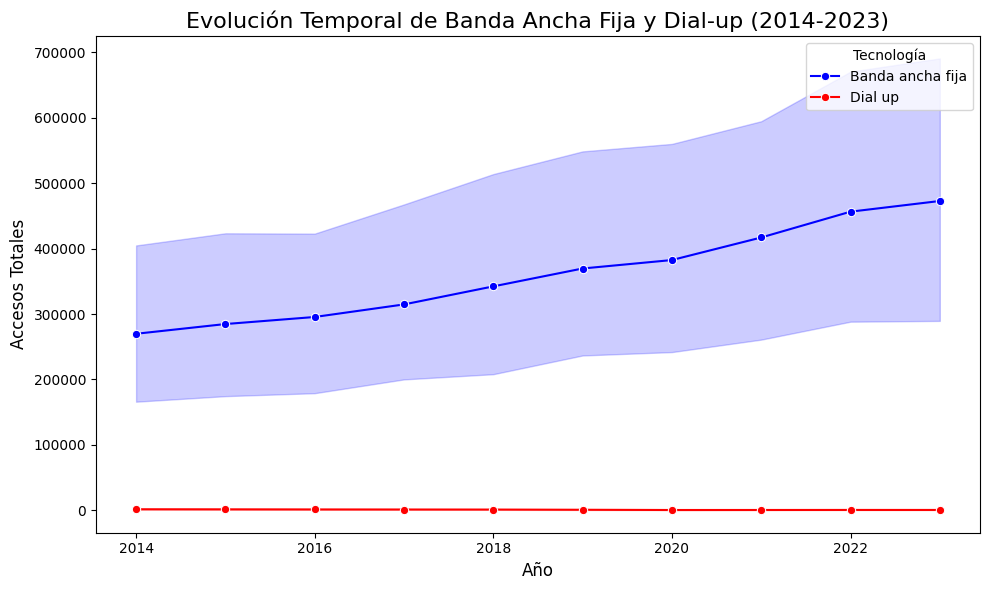

In [43]:
# Filtrar los datos para que solo incluyan los años entre 2014 y 2023
evolucion_temporal_filtrado = Dial_BAf[(Dial_BAf['Año'] >= 2014) & (Dial_BAf['Año'] <= 2023)]

# Crear el gráfico de líneas para los años 2014 a 2023
plt.figure(figsize=(10, 6))
sns.lineplot(data=evolucion_temporal_filtrado, x='Año', y='Banda ancha fija', label='Banda ancha fija', marker='o', color='b')
sns.lineplot(data=evolucion_temporal_filtrado, x='Año', y='Dial up', label='Dial up', marker='o', color='r')
plt.title('Evolución Temporal de Banda Ancha Fija y Dial-up (2014-2023)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Accesos Totales', fontsize=12)
plt.legend(title='Tecnología')
plt.tight_layout()
plt.show()

- Tendencia Creciente de Banda Ancha Fija: Desde 2014, la cantidad de accesos a Banda Ancha Fija ha tenido un crecimiento constante hasta 2023.
- Dial-up Estancado: El uso de Dial-up ha permanecido prácticamente constante y en niveles extremadamente bajos durante todo el período, lo que indica que la transición hacia tecnologías más avanzadas como la Banda Ancha Fija ya está completamente consolidada.

- La adopción de Banda Ancha Fija ha sido dominante y ha mostrado un crecimiento sostenido en la última década, mientras que Dial-up está prácticamente obsoleto. Por lo que la empresa debería priorizar las inversiones en infraestructura de Banda Ancha Fija y descontinuar el soporte para Dial-up.

#### Evaluemos los Ingresos

In [44]:
ingresos.head()

,Año,Trimestre,Ingresos (miles de pesos),Periodo
0,2024,1,2.804191e+08,Ene-Mar 2024
1,2023,4,1.673760e+08,Oct-Dic 2023
2,2023,3,1.331066e+08,Jul-Sept 2023
3,2023,2,1.180603e+08,Jun-Mar 2023
4,2033,1,1.041350e+08,Ene-Mar 2023


In [45]:
ingresos.isnull().sum() # veamos si hay nulos

Año                          0
Trimestre                    0
Ingresos (miles de pesos)    0
Periodo                      0
dtype: int64

In [46]:
duplicados = ingresos.duplicated().sum() # veamos si hay duplicados
duplicados

0

Nos encontramos con un valor 2033 que debería ser 2023, vamos a solucionarlo.

In [47]:
# Reemplazar el valor incorrecto de 2033 por 2023 en la columna 'Año'
ingresos['Año'] = ingresos['Año'].replace(2033, 2023)

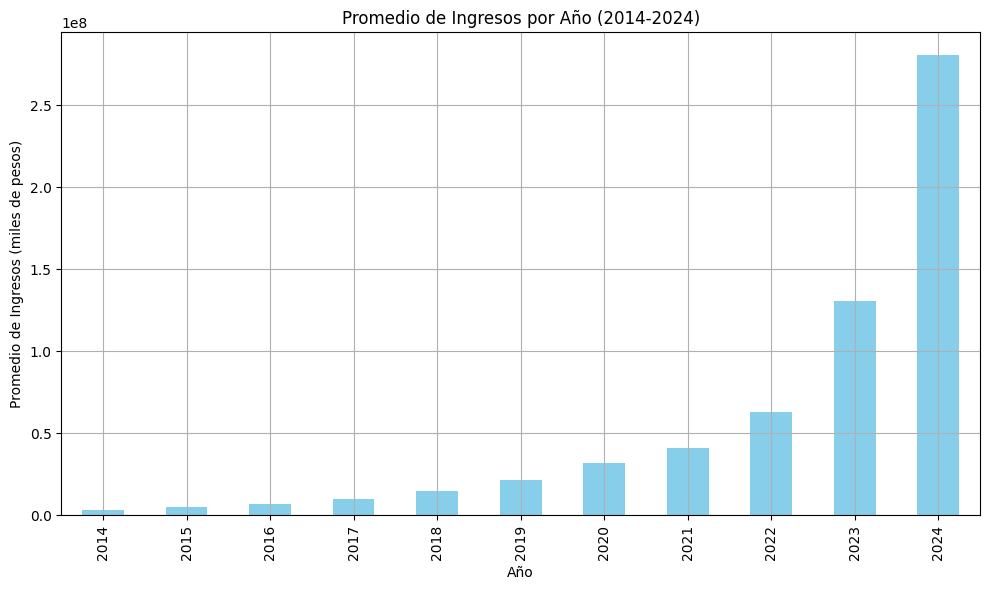

In [48]:
# Agrupar por año para mostrar el promedio anual
promedio_anual = ingresos.groupby('Año')['Ingresos (miles de pesos)'].mean()

# Gráfico de barras para promedio de ingresos anuales
plt.figure(figsize=(10, 6))
promedio_anual.plot(kind='bar', color='skyblue')
plt.title('Promedio de Ingresos por Año (2014-2024)')
plt.xlabel('Año')
plt.ylabel('Promedio de Ingresos (miles de pesos)')
plt.grid(True)
plt.tight_layout()
plt.show()

- Crecimiento sostenido: Se observa un crecimiento constante en los ingresos, especialmente a partir de 2020. Los ingresos aumentan de manera más acelerada a partir de 2021, lo que podría indicar un aumento en la demanda de servicios de TV por suscripción o incrementos en los precios.

- Crecimiento exponencial reciente: El aumento de los ingresos en 2023 y 2024 es notablemente elevado. Este salto tan grande podría deberse a múltiples factores, como aumentos en tarifas de suscripción, expansión de la cobertura, o un aumento significativo en la base de usuarios.

- Impacto del contexto económico: Este crecimiento también puede reflejarse en un contexto de inflación, donde los valores monetarios aumentan drásticamente debido a la depreciación del valor de la moneda o la necesidad de ajustar precios para compensar la inflación.

- Tendencia futura: Si esta tendencia de crecimiento se mantiene, la empresa podría esperar mayores ingresos en los próximos años, lo que sugiere una buena posición en el mercado. Sin embargo, sería relevante analizar las causas específicas de este crecimiento para evaluar si es sostenible o si requiere ajustes estratégicos.

Comparemos los ingresos con los del año pasado, teniendo en cuenta que los últimos datos son del 2023

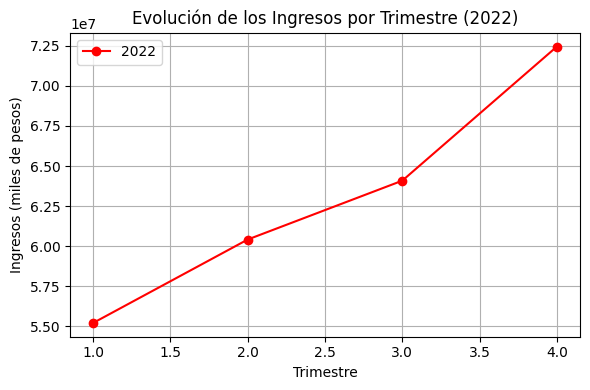

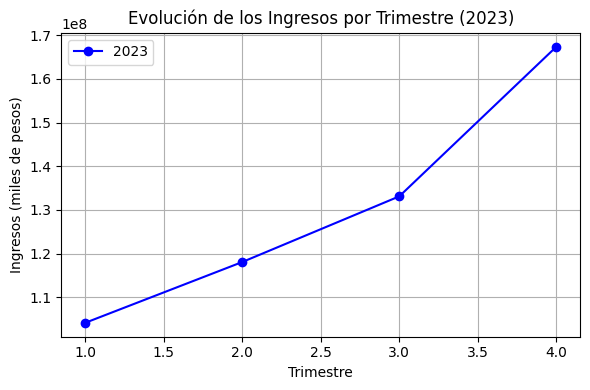

In [49]:
# Filtrar los datos para los años 2022 y 2023
ingresos_2022 = ingresos[ingresos['Año'] == 2022]
ingresos_2023 = ingresos[ingresos['Año'] == 2023]

# Crear el gráfico para el año 2022
plt.figure(figsize=(6, 4))
plt.plot(ingresos_2022['Trimestre'], ingresos_2022['Ingresos (miles de pesos)'], marker='o', linestyle='-', color='r', label='2022')
plt.title('Evolución de los Ingresos por Trimestre (2022)')
plt.xlabel('Trimestre')
plt.ylabel('Ingresos (miles de pesos)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Crear el gráfico para el año 2023
plt.figure(figsize=(6, 4))
plt.plot(ingresos_2023['Trimestre'], ingresos_2023['Ingresos (miles de pesos)'], marker='o', linestyle='-', color='b', label='2023')
plt.title('Evolución de los Ingresos por Trimestre (2023)')
plt.xlabel('Trimestre')
plt.ylabel('Ingresos (miles de pesos)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

- Crecimiento más acelerado en 2023: La evolución de los ingresos durante los trimestres de 2023 muestra un crecimiento mucho más pronunciado en comparación con el año 2022. Mientras que en 2022 los ingresos aumentaron de manera constante pero moderada (de aproximadamente 5.5 millones a 7 millones de pesos por trimestre), en 2023 el crecimiento es significativamente más fuerte, pasando de alrededor de 75 millones de pesos en el primer trimestre a 170 millones de pesos en el cuarto trimestre.

- Mayor incremento en el cuarto trimestre de 2023: En 2023, el cuarto trimestre destaca por ser el período con el mayor aumento en los ingresos, lo que indica un impulso en la demanda o en los servicios proporcionados durante ese período. Lo que sugiere una tendencia positiva hacia un crecimiento acelerado en 2023, probablemente debido a un aumento en la demanda, mejoras en los servicios o estrategias más eficaces de ventas y marketing. Esto podría llevar a la empresa a enfocarse en seguir impulsando esta tendencia positiva en 2024.

### Importamos el dataset de Televisión para sumar este servicio al análisis

In [50]:
# Leer todas las hojas del archivo Excel
television_dataset = 'Datasets\Television.xlsx'
television_file = pd.ExcelFile(television_dataset)

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\724964603.py:2: SyntaxWarning: invalid escape sequence '\T'
  television_dataset = 'Datasets\Television.xlsx'


#### Accedemos a las hojas que consideramos relevantes

In [51]:
Accesos_prov_TV = pd.read_excel(television_file, sheet_name='Accesos_prov_TV')
Ingresos_TV = pd.read_excel(television_file, sheet_name='Ingresos_TV')
Penetracion_prov_TV = pd.read_excel(television_file, sheet_name='Penetracion_prov_TV')

#### Analicemos los accesos por provincia para la televisión en cuanto a suscripciones

In [52]:
Accesos_prov_TV.head()

,Año,Trimestre,Provincia,Accesos TV por suscripción (Vrf)
0,2024,1,Buenos Aires,3000167
1,2024,1,Capital Federal,705786
2,2024,1,Catamarca,51061
3,2024,1,Chaco,116721
4,2024,1,Chubut,77969


verificamos si hay nulos

In [53]:
# Verificamos si hay valores nulos
Accesos_prov_TV.isnull().sum()

Año                                 0
Trimestre                           0
Provincia                           0
Accesos TV por suscripción (Vrf)    0
dtype: int64

In [54]:
duplicados2 = Accesos_prov_TV.duplicated()
duplicados2.sum()

0

chequeamos los rangos

In [55]:
# Verificamos los rangos de los valores de años y trimestres
Accesos_prov_TV['Año'].unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014],
      dtype=int64)

chequeamos los trimestres

In [56]:
Accesos_prov_TV['Trimestre'].unique()

array([1, 4, 3, 2], dtype=int64)

Vemos que los datos son los esperados, en cuanto a su contenido y formato

In [57]:
# Verificamos el tipo de los valores numéricos
Accesos_prov_TV.dtypes

Año                                  int64
Trimestre                            int64
Provincia                           object
Accesos TV por suscripción (Vrf)     int64
dtype: object

In [58]:
# Calcula el rango intercuartílico
Q1 = Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'].quantile(0.25)
Q3 = Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'].quantile(0.75)
IQR = Q3 - Q1

# Define límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtra los outliers
df_clean = Penetracion_prov_TV[(Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] >= lower_bound) & (Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] <= upper_bound)]


In [59]:
# Reemplazar outliers con la mediana
mediana = df_clean['Accesos TV por suscripción por cada 100 hogares'].median()
Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] = np.where((Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] > upper_bound) | (Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] < lower_bound ), mediana, Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'])


In [60]:
Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares']
media = Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'].mean()
mediana = Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'].median()
moda = Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'].mode()[0]

media



45.24813329543377

In [61]:
# Escalar los valores multiplicando por 100000
Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] *= 100000

# Redondear los valores a 2 decimales (o al número de dígitos que prefieras)
Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] = Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'].round(2)


In [62]:
min(Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'])

1255698.41

In [63]:
# Guardar el DataFrame ajustado a un nuevo archivo CSV si es necesario
Penetracion_prov_TV.to_csv('Penetracion_prov_TV_escalado.csv', index=False)

In [64]:
# Filtrar valores extremos
outliers = Penetracion_prov_TV[Penetracion_prov_TV['Accesos TV por suscripción por cada 100 hogares'] > 1e7] # Ajusta el umbral según sea necesario
print(outliers)

Empty DataFrame
Columns: [Año, Trimestre, Provincia, Accesos TV por suscripción por cada 100 hab, Accesos TV por suscripción por cada 100 hogares]
Index: []


Hagamos el siguiente gráfico, el cual proporcionará una visión general de cómo la televisión por suscripción ha penetrado en el mercado a nivel provincial, permitiendo a la empresa tomar decisiones informadas sobre dónde enfocar sus esfuerzos futuros. Además, muestra de manera clara las provincias donde la empresa ya ha alcanzado una penetración sólida, lo que es útil para la planificación a largo plazo y la optimización de recursos.

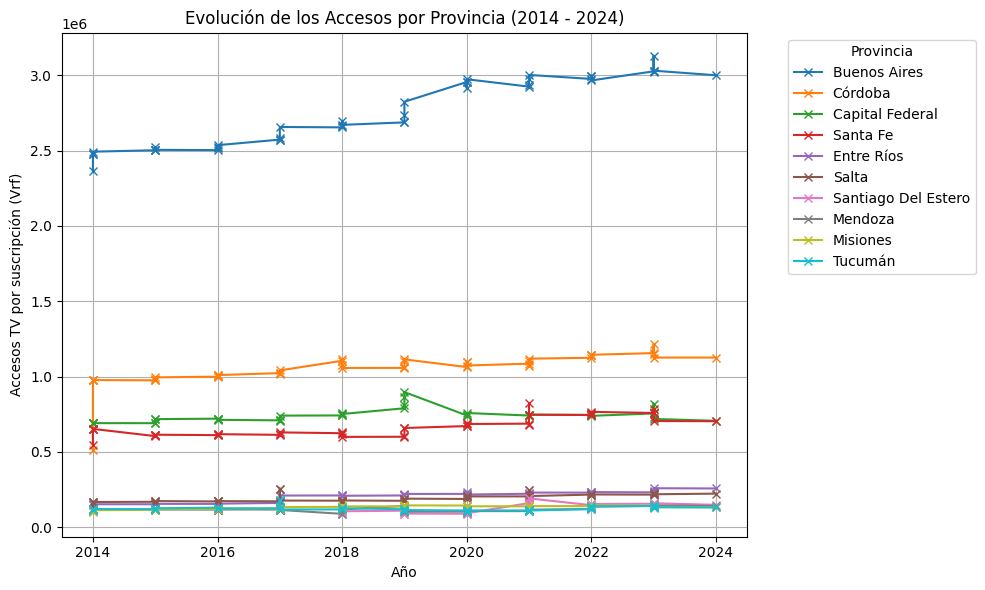

In [65]:
# Seleccionar las provincias con mayor cantidad de accesos en 2024 (puedes ajustar esto según lo que te interese)
top_provincias = Accesos_prov_TV[Accesos_prov_TV['Año'] == 2024].nlargest(10, 'Accesos TV por suscripción (Vrf)')['Provincia']

# Filtrar el dataframe para solo incluir esas provincias
df_top = Accesos_prov_TV[Accesos_prov_TV['Provincia'].isin(top_provincias)]

# Generar el gráfico
plt.figure(figsize=(10, 6))
for provincia in top_provincias:
    data_provincia = df_top[df_top['Provincia'] == provincia]
    plt.plot(data_provincia['Año'], data_provincia['Accesos TV por suscripción (Vrf)'], marker='x', label=provincia)

plt.title('Evolución de los Accesos por Provincia (2014 - 2024)')
plt.xlabel('Año')
plt.ylabel('Accesos TV por suscripción (Vrf)')
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Si analizamos el gráfico anterior, podemos ver que:
- Buenos Aires tiene consistentemente el mayor número de accesos a TV por suscripción, y ha mostrado un leve aumento en el periodo analizado.
- Capital Federal, Córdoba, y Santa Fe siguen siendo las provincias con un número significativo de accesos, aunque sin grandes cambios a lo largo de los años.
- Otras provincias como Tucumán, Misiones, y Salta tienen accesos significativamente menores en comparación con las provincias principales.
- La mayoría de las provincias muestran un crecimiento estable o ligeramente ascendente, sin grandes picos o caídas bruscas, lo que podría indicar una penetración ya establecida en estos mercados.

#### Veamos la penetración de TV por suscripción por provincia

In [66]:
Penetracion_prov_TV.head()

,Año,Trimestre,Provincia,Accesos TV por suscripción por cada 100 hab,Accesos TV por suscripción por cada 100 hogares
0,2024,1,Buenos Aires,16.53,4824000.0
1,2024,1,Capital Federal,22.88,5607000.0
2,2024,1,Catamarca,11.93,4689000.0
3,2024,1,Chaco,9.37,3504000.0
4,2024,1,Chubut,11.89,3878000.0


Veamos su distribución por cada 100 hogares en las diferentes provincias

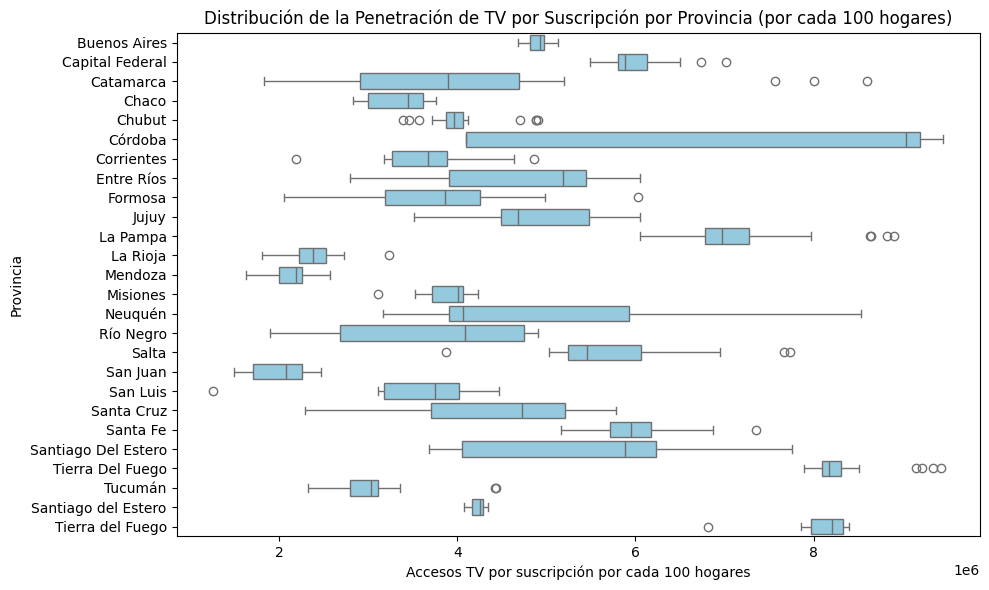

In [67]:
# Crear gráfico de cajas para visualizar la distribución de penetración por provincia
plt.figure(figsize=(10, 6))
sns.boxplot(x='Accesos TV por suscripción por cada 100 hogares', y='Provincia', data=Penetracion_prov_TV, color='skyblue')

# Títulos y etiquetas
plt.xlabel('Accesos TV por suscripción por cada 100 hogares')
plt.ylabel('Provincia')
plt.title('Distribución de la Penetración de TV por Suscripción por Provincia (por cada 100 hogares)')
plt.tight_layout()

plt.show()

- Rangos de Penetración:
Las provincias como Buenos Aires, Capital Federal, y Tierra del Fuego tienen una penetración más consistente con menor variabilidad, lo que sugiere que la penetración de TV por suscripción en estas provincias está más establecida.
Provincias como Santa Fe y Mendoza presentan una mayor dispersión en la penetración, indicando que hay regiones dentro de estas provincias con una penetración muy variada.

- Valores Atípicos:
En provincias como Tierra del Fuego y Santa Cruz, se observan valores atípicos (outliers). Estos pueden indicar áreas específicas dentro de estas provincias donde la penetración es significativamente diferente del resto.
Esto podría sugerir que algunas regiones tienen un acceso mucho mayor o mucho menor a la TV por suscripción comparado con el promedio provincial.

- Mediana:
La línea negra dentro de las cajas representa la mediana de la penetración por suscripción en cada provincia. Algunas provincias, como La Pampa y Catamarca, tienen medianas más altas que otras, lo que indica que la penetración de TV por suscripción es alta en más del 50% de los 
casos.

- Variabilidad dentro de las Provincias:
Algunas provincias tienen una caja más pequeña (p. ej., San Luis), lo que indica poca variabilidad y una penetración bastante homogénea. Por otro lado, provincias como Corrientes y Santiago del Estero tienen una caja más grande, lo que indica que hay más variabilidad en la penetración.

- Relevancia para la Empresa:
Este gráfico es relevante para la empresa porque permite identificar provincias donde hay oportunidades de mejorar la penetración del servicio. Las provincias con gran variabilidad pueden indicar un mercado con potencial para crecimiento, ya que hay zonas dentro de esas provincias con baja penetración que pueden ser exploradas comercialmente. Además, el análisis de outliers puede sugerir regiones particulares que podrían beneficiarse de campañas de marketing más enfocadas o mejoras en infraestructura.

Veamos las provincias que tienen menor penetración por cada 100 hogares

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\1811527294.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accesos TV por suscripción por cada 100 hogares', y='Provincia', data=penetracion_ordenada, palette='coolwarm')


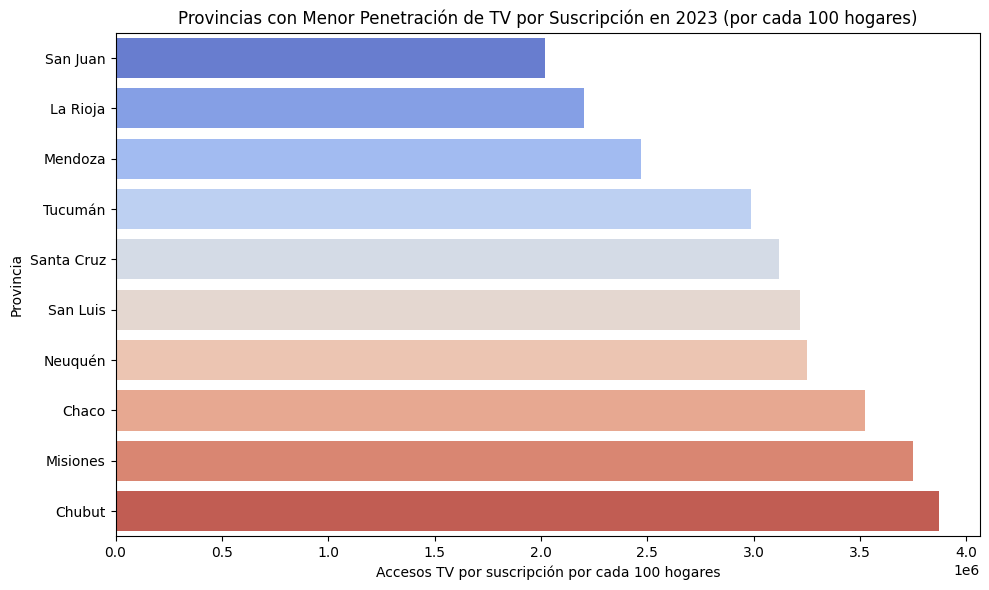

In [68]:
# Filtrar los registros para el año 2023
penetracion_2023 = Penetracion_prov_TV[Penetracion_prov_TV['Año'] == 2023]

# Asegurarse de que no haya valores duplicados ni NaN en la columna de penetración
penetracion_prov_clean = penetracion_2023.dropna(subset=['Accesos TV por suscripción por cada 100 hogares'])

# Ordenar las provincias por menor penetración por cada 100 hogares y seleccionar las 10 con menor penetración
penetracion_ordenada = penetracion_prov_clean.sort_values('Accesos TV por suscripción por cada 100 hogares').drop_duplicates(subset=['Provincia']).head(10)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Accesos TV por suscripción por cada 100 hogares', y='Provincia', data=penetracion_ordenada, palette='coolwarm')

# Personalizar el gráfico
plt.title('Provincias con Menor Penetración de TV por Suscripción en 2023 (por cada 100 hogares)')
plt.xlabel('Accesos TV por suscripción por cada 100 hogares')
plt.ylabel('Provincia')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Estas provincias podrían ser áreas con potencial para aumentar la suscripción, ya sea a través de campañas de marketing, promociones, o mejoras en la oferta de servicios.
Focalización de Inversiones: La empresa podría usar este análisis para focalizar sus inversiones en estas regiones, mejorando la infraestructura y asegurándose de que se atiendan las necesidades de los clientes.

#### Analicemos la hoja de Ingresos por el servicio de TV

Realizamos una limpieza a los campos de la hoja Ingresos con el fin de que los datos estén aptos para la realización de los gráficos.

In [69]:
# Normalizar los nombres de las columnas
Ingresos_TV.columns = Ingresos_TV.columns.str.strip() \
                                        .str.replace(r'\s+', ' ', regex=True)
# Mostrar los nuevos nombres de las columnas para confirmar
print(Ingresos_TV.columns)

Index(['Año', 'Trimestre', 'Ingresos TV por suscripción (miles de $)',
       'Ingresos TV satelital (miles de $)'],
      dtype='object')


Hagamos un análisis para ver cómo se han venido desarrollando los ingresos de la empresa en este servicio en el último año

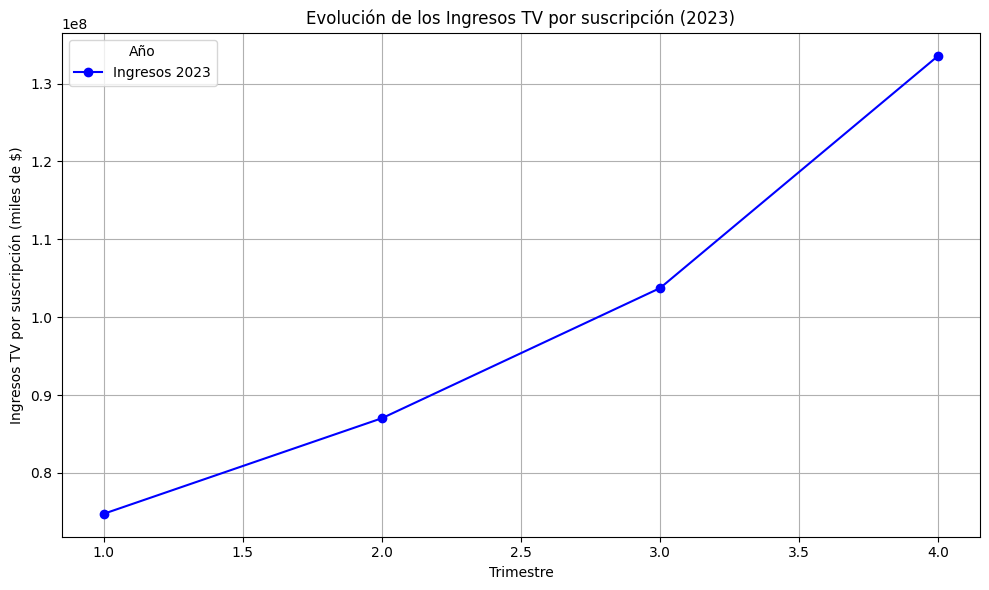

In [70]:
# Filtrar solo los datos del 2023
Ingresos_TV_2023 = Ingresos_TV[Ingresos_TV['Año'] == 2023]

# Crear el gráfico para 2023
plt.figure(figsize=(10, 6))

# Graficar la evolución de los ingresos por trimestre
plt.plot(Ingresos_TV_2023['Trimestre'], Ingresos_TV_2023['Ingresos TV por suscripción (miles de $)'], 
         marker='o', linestyle='-', color='b', label="Ingresos 2023")

plt.title('Evolución de los Ingresos TV por suscripción (2023)')
plt.xlabel('Trimestre')
plt.ylabel('Ingresos TV por suscripción (miles de $)')
plt.legend(title='Año')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

- Crecimiento constante: Hay un incremento progresivo y constante de los ingresos a lo largo de los trimestres de 2023. Esto sugiere una tendencia positiva y sostenida en las suscripciones de TV durante el año.

- Aumento notable en el cuarto trimestre: Se observa un mayor aumento en los ingresos en el último trimestre del año, lo que podría deberse a diferentes factores, como promociones estacionales, mayor demanda de suscripciones durante el fin de año o lanzamientos de contenido atractivo que generaron más suscripciones.

- Posible oportunidad de expansión: Este comportamiento creciente sugiere que la empresa está en un buen momento para continuar expandiéndose o invirtiendo en estrategias que mantengan o aumenten este ritmo de crecimiento. Los datos sugieren que las suscripciones continúan siendo una fuente de ingresos sólida y en expansión.

- Estacionalidad: Aunque no se observan caídas, es importante revisar si este crecimiento es estacional o si la tendencia se mantiene constante durante otros años.

Guardamos las hojas trabajadas como archivos csv para luego importar

In [71]:
'''# Guardar las hojas de internet_file en archivos CSV
accesos_por_tecnologia.to_csv('accesos_por_tecnologia.csv', index=False)
penetracion_poblacion.to_csv('penetracion_poblacion.csv', index=False)

# Guardar las hojas de television_file en archivos CSV
Accesos_prov_TV.to_csv('accesos_prov_TV.csv', index=False)
Ingresos_TV.to_csv('ingresos_TV.csv', index=False)
Penetracion_prov_TV.to_csv('penetracion_prov_TV.csv', index=False)'''

"# Guardar las hojas de internet_file en archivos CSV\naccesos_por_tecnologia.to_csv('accesos_por_tecnologia.csv', index=False)\npenetracion_poblacion.to_csv('penetracion_poblacion.csv', index=False)\n\n# Guardar las hojas de television_file en archivos CSV\nAccesos_prov_TV.to_csv('accesos_prov_TV.csv', index=False)\nIngresos_TV.to_csv('ingresos_TV.csv', index=False)\nPenetracion_prov_TV.to_csv('penetracion_prov_TV.csv', index=False)"